# TCC - Estudo da base de alvarás de Curitiba

Estrutura básica do código:
 - Importações das bibliotecas
 - Definições das funções
 - Programa em si

<b>Resumo do funcionamento:</b><br>
Leitura das tabelas que estão no banco SQL chamado BIGSEA, contendo os dados já tratados sobre a cidade de Curitiba e posterior tratamento e análise exploratória feitos em Python.

<b>Instrução prévia, antes de rodar este programa:</b><br>
Abrir o <b>PuTTy</b> e rodar a conexão <b>C3SL</b>, para estabelecer a conexão com o banco SQL BIGSEA.

# Importação das bibliotecas

In [1]:
import pandas as pd
import numpy as np

import datetime as dt

import geopandas as gpd

import psycopg2

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

# Definição de funções e variáveis globais

In [3]:
lista_retirar = ['MOTORISTA DE TAXI',
'PEDREIRO',
'GARÇOM',
'MOTORISTA DE VEÍCULOS DE CARGA',
'COSTUREIRO',
'ENTREGADOR DE ENCOMENDAS COM MOTOCICLETA',
'PINTOR NA CONSTRUÇÃO CIVIL',
'SUPORTE TÉCNICO, MANUTENÇÃO E OUTROS SERVIÇOS EM T',
'DIGITADOR',
'ESTETICISTA',
'COZINHEIRO',
'CARPINTEIRO',
'MOTORISTA DE VEÍCULOS DE TRANSPORTE ESCOLAR',
'CARREGADOR DE VOLUMES',
'INSTALAÇÃO E MANUTENÇÃO ELÉTRICA',
'CONSULTORIA EM TECNOLOGIA DA INFORMAÇÃO',
'JARDINEIRO',
'DESENVOLVIMENTO DE PROGRAMAS DE COMPUTADOR SOB ENC',
'MONTADOR DE MÓVEIS',
'GUARDIÃO',
'COBRADOR',
'FOTÓGRAFO',
'PORTAIS, PROVEDORES DE CONTEÚDO E OUTROS SERVIÇOS ',
'FORNECIMENTO DE ALIMENTOS PREPARADOS PREPONDERANTE',
'DATILÓGRAFO',
'ENCANADOR',
'REPARAÇÃO E MANUTENÇÃO DE EQUIPAMENTOS ELETROELETR',
'GUIA DE TURISMO',
'REPARADOR DE EQUIPAMENTOS ELETRO-ELETRÔNICOS',
'ATOR',
'OUTRAS ATIVIDADES DE ENSINO NÃO ESPECIFICADAS ANTE',
'LIMPEZA EM PRÉDIOS E EM DOMICÍLIOS',
'ARTISTA',
'SERVIÇOS DE ENTREGA RÁPIDA',
'CORRETOR DE SEGUROS',
'MANUTENÇÃO E REPARAÇÃO DE MÁQUINAS E EQUIPAMENTOS ',
'CONTADOR',
'EDIÇÃO DE LIVROS',
'MASSAGISTA',
'AZULEJISTA',
'LAVADEIRO',
'INSTRUTOR DE MUSCULAÇÃO',
'ADESTRADOR DE ANIMAIS',
'ENFERMEIRO',
'CALISTA',
'FIGURINISTA',
'ROTEIRISTA',
'RADIALISTA',
'INSTRUTOR DE CAPOEIRA',
'TRATORISTA',
'REPARADOR DE BOX PARA BANHEIRO',
'TAXIDERMISTA',
'ADERECISTA',
'ESTILISTA',
'ÁRBITRO DESPORTIVO',
'REPARADOR DE ELETRODOMÉSTICOS', 
'INSTALADOR DE ANTENAS', 
'BORDADEIRO', 
'COLOCADOR DE CARPETE', 
'INSTALADOR DE APARELHOS E/OU LINHAS TELEFÔNICAS', 
'INSTALADOR DE ALARMES NA CONSTRUÇÃO CIVIL', 
'TÉCNICO CINEMATOGRÁFICO', 
'PINTOR DE FAIXAS E CARTAZES', 
'LIXADOR DE ASSOALHOS', 
'REPARADOR DE JÓIAS', 
'LUSTRADOR', 
'REPARADOR DE MAQUINAS DE ESCRITÓRIO', 
'REPARADOR DE ELEVADORES', 
'DOMADOR DE ANIMAIS', 
'SERVIÇOS AMBULANTES DE ALIMENTAÇÃO', 
'REPARADOR DE ARTIGOS ESPORTIVOS', 
'DANÇARINO', 
'CENOTÉCNICO', 
'DETETIVE', 
'AGENCIADOR DE ASSINATURAS DE JORNAIS E REVISTAS'
]

In [4]:
# Leitura da base de ruas temáticas
df_tematicas = pd.read_csv('../auxiliares/locais_tematicos.csv', encoding = 'utf-8')

In [5]:
def Conecta_Pgadmin(db_name):
    conn = psycopg2.connect(host = 'localhost', database = db_name, port = '5435', user = 'postread', password = 'PostRead')
    return conn

In [6]:
def Base_Alvaras():
    nome_tabela = "prefeitura.alvara"
    postgreSQL_select_Query = "SELECT * FROM " + nome_tabela
    df_alvaras_raw = pd.read_sql(postgreSQL_select_Query, Conecta_Pgadmin('postgiscwb'))
    return df_alvaras_raw

In [7]:
def Mapa_Curitiba_Bairros():
    gdf_mapa_bairros = gpd.GeoDataFrame.from_postgis("SELECT * FROM limites_legais.divisa_de_bairros", Conecta_Pgadmin('bigsea'), geom_col='geom', crs=5533).to_crs(4326)
    return gdf_mapa_bairros

In [8]:
def Converte_Numeros(texto_num):    
    if type(texto_num) == type(' '): # Faz-se uma conversão apenas se for detectado que o tipo é str
        texto_num = texto_num.replace('.','') # Retira-se o caractere ponto
        
        # Tratamento dos casos "Sem número", conforme as diferentes grafias
        if (('S' in texto_num.upper()) and ('N' in texto_num.upper())): 
            num = 'S/N'
        
        # Casos em que o não há problemas e que todos os caracteres são dígitos e casos em que o complemento está junto do número
        else:
            # Busca-se pelo primeiro caractere não numérico
            ind_nnum = 0
            for i in range(len(texto_num)):
                if (texto_num[i].isnumeric() == False):
                    ind_nnum = i
                    break
            
            # Seleciona-se para converter apenas o que ficou antes do 1o caractere não numérico
            # e apenas se houver esse caractere
            if ind_nnum > 0:
                texto_num = texto_num[:ind_nnum]
                
            num = int(texto_num)
            
        
    elif type(texto_num) == type(1): # Caso a entrada já esteja em formato int, mantém-se
        num = texto_num
        
    else:
        num = 0
    
    return num

In [9]:
def Uniformiza_Ruas(nome_corrigir):
    nome = nome_corrigir
    
    pref_manter = ['R.', 'AV.', 'AL.', 'PC.']
    
    trocas_pref = {'RUA':'R.', 'TRAVESSA':'TV.', 'AVENIDA':'AV.', 'ALAMEDA':'AL.', 'PRACA':'PC.', 'ESTRADA':'EST.', 'RUA:':'R.', 'PRAÇA':'PC.', 'RODOVIA':'ROD.', 'R':'R.', 'AV':'AV.', 'RUADR':'R.', 'AV,':'AV.', 'LARGO':'LG.', 'TV':'TV.'}
    
    trocas_nomes = {'R. EST. GUILHERME WEIGERT':'EST. GUILHERME WEIGERT', 'R. PRESIDENTE JOAO GOULART':'R. PRESIDENTE JOÃO GOULART', 'AV. CANAL BELEM':'AV. CANAL BELÉM', 'R. CANAL BELEM':'AV. CANAL BELÉM', 'AV. JUSCELINO KUBITSCHEKI DE OLIVEIRA':'AV. JUSCELINO KUBITSCHEK DE OLIVEIRA', 'R. DES. CID CAMPELO':'R. DESEMBARGADOR CID CAMPELO', 'R. TV. MEDIANEIRA':'TV. MEDIANEIRA', 'R. CID CAMPELO':'R. DESEMBARGADOR CID CAMPELO', 'R. DES.CID CAMPELO':'R. DESEMBARGADOR CID CAMPELO', 'R. MEDIANEIRA':'TV. MEDIANEIRA', 'TV. ALEXANDRE GUTIERREZ BELTRÃO':'TV. ALEXANDRE GUTIERREZ BELTRÃO', 'R. JUSCELINO KUBITSCHEK DE OLIVEIRA':'AV. JUSCELINO KUBITSCHEK DE OLIVEIRA', 'R. GUILHERME WEIGERT':'EST. GUILHERME WEIGERT', 'AV. IZAAC FERREIRA DA CRUZ':'R. IZAAC FERREIRA DA CRUZ', 'AV. JUSCELINO KUBITSCHECK DE OLIVEIRA':'AV. JUSCELINO KUBITSCHEK DE OLIVEIRA', 'R. ANITA GARIBALDI':'AV. ANITA GARIBALDI', 'R. BRASÍLIO DE LARA':'R. BRASILIO DE LARA', 'AV. PRES. JOÃO GOULART':'R. PRESIDENTE JOÃO GOULART', 'AV. PRESIDENTE JOAO GOULART':'R. PRESIDENTE JOÃO GOULART', 'R. JUSCELINO KUBITSCKEK DE OLIVEIRA':'AV. JUSCELINO KUBITSCHEK DE OLIVEIRA', 'R. JOÃO GOULART':'R. PRESIDENTE JOÃO GOULART', 'R. DESEMBAGADOR CID CAMPELO':'R. DESEMBARGADOR CID CAMPELO', 'R. TV. RAFAEL FRANCISCO GRECA':'TV. RAFAEL FRANCISCO GRECA', 'R. TV. OLIVEIRA BELLO':'TV. OLIVEIRA BELLO', 'R. TV. DA LAPA':'TV. DA LAPA', 'R. TV. ITARARÉ':'TV. ITARARÉ', 'R. TV. NESTOR DE CASTRO':'TV. NESTOR DE CASTRO', 'R. TV. LANGE':'TV. LANGE', 'R. TV. FERREIRA DO AMARAL':'TV. FERREIRA DO AMARAL', 'R. TV. TOBIAS DE MACEDO':'TV. TOBIAS DE MACEDO', 'R. TV. PERCY WITHERS':'TV. PERCY WITHERS', 'R. TV. JOÃO TURIN':'TV. JOÃO TURIN', 'R. TV. CAPITÃO CLEMENTINO PARANÁ':'TV. CAPITÃO CLEMENTINO PARANÁ', 'R. TV. TEIXEIRA DE FREITAS':'TV. TEIXEIRA DE FREITAS', 'R. TV. DOUTOR FLAVIO LUZ':'TV. DOUTOR FLAVIO LUZ', 'R. TV. AMANDO MANN':'TV. AMANDO MANN', 'R. TV. JESUINO MARCONDES':'TV. JESUINO MARCONDES', 'R. TV. DOS EDITORES':'TV. DOS EDITORES', 'R. TV. DOS MARCENEIROS':'TV. DOS MARCENEIROS', 'R. TV. JOÃO SCHAFFER JÚNIOR':'TV. JOÃO SCHAFFER JÚNIOR', 'R. TV. CORONEL SILVIO VAN ERVEN':'TV. CORONEL SILVIO VAN ERVEN', 'R. TV. FREI CANECA':'TV. FREI CANECA', 'R. TV. GENERAL FRANCISCO LIMA E SILVA':'TV. GENERAL FRANCISCO LIMA E SILVA', 'R. TV. JOÃO BONN':'TV. JOÃO BONN', 'R. TV. ALBINO MARCOLINO ANTUNES':'TV. ALBINO MARCOLINO ANTUNES', 'R. TV. AUGUSTO MARACH':'TV. AUGUSTO MARACH', 'R. TV. ARMANDO CARVALHO CHAVES':'TV. ARMANDO CARVALHO CHAVES', 'R. TV. DOUTOR LOURIVAL SCHWANSEE TÔRRES':'TV. DOUTOR LOURIVAL SCHWANSEE TÔRRES', 'R. TV. SANTA INÊS':'TV. SANTA INÊS', 'R. TV. ITÁLIA':'TV. ITÁLIA', 'R. TV. ÂNGELO PIAZZETTA':'TV. ÂNGELO PIAZZETTA', 'R. TV. SÃO BENEDITO':'TV. SÃO BENEDITO', 'R. TV. NEY AZEVEDO':'TV. NEY AZEVEDO', 'R. TV. MADRE JULIA':'TV. MADRE JULIA', 'R. TV. GILMAR CEZAR PIEKARSKI':'TV. GILMAR CEZAR PIEKARSKI', 'R. TV. ABÍLIO CESAR BORGES':'TV. ABÍLIO CESAR BORGES', 'R. TV. ARNALDO FERREIRA DE ABREU':'TV. ARNALDO FERREIRA DE ABREU', 'R. TV. ALEXANDRE GUTIERREZ BELTRÃO':'TV. ALEXANDRE GUTIERREZ BELTRÃO', 'R. TV. ALBERICO FIGUEIRA':'TV. ALBERICO FIGUEIRA', 'R. TV. NELSON GONÇALVES DE LIMA':'TV. NELSON GONÇALVES DE LIMA', 'R. TV. RAFAELA VIDAL CHAGAS':'TV. RAFAELA VIDAL CHAGAS', 'R. TV. JOSÉ DO PATROCÍNIO':'TV. JOSÉ DO PATROCÍNIO', 'R. TV. MAURO GONÇALVES- ZACARIAS':'TV. MAURO GONÇALVES- ZACARIAS', 'R. TV. MAJOR CORREIA LIMA':'TV. MAJOR CORREIA LIMA', 'R. TV. VIRGILIO GOMES PINHEIRO':'TV. VIRGILIO GOMES PINHEIRO', 'R. TV. JOSÉ SURUGI':'TV. JOSÉ SURUGI', 'R. TV. ALCIONI CAMARGO DE QUEIROZ':'TV. ALCIONI CAMARGO DE QUEIROZ', 'R. TV. ADOLAR COIMBRA':'TV. ADOLAR COIMBRA', 'R. TV. FERREIRA':'TV. FERREIRA', 'R. TV. ELIAS KALIL KARAM':'TV. ELIAS KALIL KARAM', 'R. TV. OTÁVIO RIBAS GUIMARÃES':'TV. OTÁVIO RIBAS GUIMARÃES', 'R. TV. MONTEIRO LOBATO':'TV. MONTEIRO LOBATO', 'R. TV. MANOEL EUGÊNIO SANZOVO MOURÃO':'TV. MANOEL EUGÊNIO SANZOVO MOURÃO', 'R. TV. LUTHERO':'TV. LUTHERO', 'R. TV. LEOCÁDIO PEREIRA DA COSTA':'TV. LEOCÁDIO PEREIRA DA COSTA', 'R. TV. KALIL KARAN':'TV. KALIL KARAN', 'R. TV. JOÃO MAX ROSENER':'TV. JOÃO MAX ROSENER', 'R. TV. VITORIO MOCELIN':'TV. VITORIO MOCELIN', 'R. TV. SOLIERI':'TV. SOLIERI', 'R. TV. TABOAO':'TV. TABOAO', 'R. TV. SELVINO CARAMORI':'TV. SELVINO CARAMORI', 'R. TV. SÃO LUCAS':'TV. SÃO LUCAS', 'R. TV. JUVENTINO MOSELE':'TV. JUVENTINO MOSELE', 'R. TV. LAURINDO ANTONIO SEGALLA':'TV. LAURINDO ANTONIO SEGALLA', 'R. TV. MARTINHO DIOGO TEIXEIRA':'TV. MARTINHO DIOGO TEIXEIRA', 'R. TV. PROFESSORA MARIA DO CARMO DE FIGUEIREDO SILVA':'TV. PROFESSORA MARIA DO CARMO DE FIGUEIREDO SILVA', 'R. TV. OCTAVIA LEAL PENTEADO':'TV. OCTAVIA LEAL PENTEADO', 'R. TV. PADRE FEIJÓ':'TV. PADRE FEIJÓ', 'R. TV. PROFESSOR ALVARO LUIZ JUNQUEIRA FRANÇA':'TV. PROFESSOR ALVARO LUIZ JUNQUEIRA FRANÇA', 'R. TV. PROFESSOR ELYSIO VIANA':'TV. PROFESSOR ELYSIO VIANA', 'R. TV. JOÃO NOCITI':'TV. JOÃO NOCITI', 'R. TV. ALICE FURLAMETTO MORET':'TV. ALICE FURLAMETTO MORET', 'R. TV. JORGE CUQUEL':'TV. JORGE CUQUEL', 'R. TV. GRACIOSA':'TV. GRACIOSA', 'R. TV. JEFERSON REIS ROSA':'TV. JEFERSON REIS ROSA', 'R. TV. JOVINO RIBEIRO':'TV. JOVINO RIBEIRO', 'R. TV. FRANCISCA PAMPUCHE ANTONIACOMI':'TV. FRANCISCA PAMPUCHE ANTONIACOMI', 'R. TV. ERNESTO LUIZ DE OLIVEIRA':'TV. ERNESTO LUIZ DE OLIVEIRA', 'R. TV. ANGELO GOLIN':'TV. ANGELO GOLIN', 'R. TV. ANTONIO LUIZ DE OLIVEIRA':'TV. ANTONIO LUIZ DE OLIVEIRA', 'R. TV. AUGUSTO KLINGENFUSS':'TV. AUGUSTO KLINGENFUSS', 'R. TV. BAGE':'TV. BAGE', 'R. TV. BOM RETIRO':'TV. BOM RETIRO', 'R. TV. CLAUDIO TYSZKA':'TV. CLAUDIO TYSZKA', 'R. TV. ELISEU MARQUES SERAFIM':'TV. ELISEU MARQUES SERAFIM', 'R. TV. ALBERTO ANTÔNIO PEREIRA':'TV. ALBERTO ANTÔNIO PEREIRA', 'R. TV. AMARILDO DALAZUANA':'TV. AMARILDO DALAZUANA', 'R. TV. GIANFRANCO BERTONI':'TV. GIANFRANCO BERTONI', 'R. TV. GALDINO ALEIXO':'TV. GALDINO ALEIXO', 'R. TV. GUSTAVO GERMANO BRAND':'TV. GUSTAVO GERMANO BRAND', 'R. TV. HERMENEGILDO GASPARINI':'TV. HERMENEGILDO GASPARINI', 'R. TV. FELICIANO ZANLORENZI':'TV. FELICIANO ZANLORENZI', 'R. TV. JORNALISTA ARAMIS MILLARCH':'TV. JORNALISTA ARAMIS MILLARCH', 'R. TV. IRMÃ JULIA':'TV. IRMÃ JULIA', 'R. TV. ESTEFANO ANTONIO SCHREDERHOF':'TV. ESTEFANO ANTONIO SCHREDERHOF', 'R. TV. CAPITÃOZINHO SCHERAIB':'TV. CAPITÃOZINHO SCHERAIB', 'R. TV. ARNOLDO KUHL':'TV. ARNOLDO KUHL', 'R. TV. ELIZABETE CHARLOTE BRAND':'TV. ELIZABETE CHARLOTE BRAND', 'R. TV. ELI VOLPATO':'TV. ELI VOLPATO', 'R. TV. EDEMEE DUTRA CALÇADO':'TV. EDEMEE DUTRA CALÇADO', 'R. TV. DA SOROCABA':'TV. DA SOROCABA', 'R. TV. DEA TAQUES DE MESQUITA':'TV. DEA TAQUES DE MESQUITA', 'R. TV. DALVINO NUNES DA LAPA':'TV. DALVINO NUNES DA LAPA', 'R. TV. JOSE BIM':'TV. JOSE BIM', 'R. TV. JOSE DARU':'TV. JOSE DARU', 'R. TV. SALVADOR GRACIANO- NHÔ BELARMINO':'TV. SALVADOR GRACIANO- NHÔ BELARMINO', 'R. TV. RUI LEAO':'TV. RUI LEAO', 'R. TV. PIO XII':'TV. PIO XII', 'R. TV. PEDRO LAZARI':'TV. PEDRO LAZARI', 'R. TV. PEDRO GREIN':'TV. PEDRO GREIN', 'R. TV. PE. EURICO DEDINO':'TV. PE. EURICO DEDINO', 'R. TV. SIMPLÍCIO FERREIRA RIBAS':'TV. SIMPLÍCIO FERREIRA RIBAS', 'R. TV. WILMAR SAUNER':'TV. WILMAR SAUNER', 'R. TV. VISTA VERDE':'TV. VISTA VERDE', 'R. TV. VALENTINA BAILO GERONAZZO':'TV. VALENTINA BAILO GERONAZZO', 'R. TV. ORONDES DOS SANTOS COSTA':'TV. ORONDES DOS SANTOS COSTA', 'R. TV. ORACY GEMBA':'TV. ORACY GEMBA', 'R. TV. LIVORNO':'TV. LIVORNO', 'R. TV. LEONARDO WERBITZKI':'TV. LEONARDO WERBITZKI', 'R. TV. LAUDEMERI RODRIGUES APOLONIO':'TV. LAUDEMERI RODRIGUES APOLONIO', 'R. TV. JOÃO PROSDÓCIMO':'TV. JOÃO PROSDÓCIMO', 'R. TV. JOÃO DUDEQUE':'TV. JOÃO DUDEQUE', 'R. TV. LOURIVAL GONÇALVES DE LARA':'TV. LOURIVAL GONÇALVES DE LARA', 'R. TV. LUDOVICO SEYER':'TV. LUDOVICO SEYER', 'R. TV. NASSIM SADO':'TV. NASSIM SADO', 'R. TV. NOEMIA VIDAL DE OLIVEIRA':'TV. NOEMIA VIDAL DE OLIVEIRA', 'R. TV. LUIZ GAMA':'TV. LUIZ GAMA', 'R. TV. MILTON DERVICHE':'TV. MILTON DERVICHE', 'R. TV. MARIA DE LOURDES PERICO KOZOSKI':'TV. MARIA DE LOURDES PERICO KOZOSKI', 'R. ROD. BR CENTO E DEZESSEIS':'ROD. BR CENTO E DEZESSEIS', "R. EST. DO GANCHINHO- LD":"EST. DO GANCHINHO- LD","R. EST. DELEGADO BRUNO DE ALMEIDA":"EST. DELEGADO BRUNO DE ALMEIDA","R. EST. DE SANTA CÂNDIDA":"EST. DE SANTA CÂNDIDA","R. EST. VELHA DO BARIGUI":"EST. VELHA DO BARIGUI","R. EST. DAS OLARIAS":"EST. DAS OLARIAS","R. EST. DA RIBEIRA BR-476":"EST. DA RIBEIRA BR-476","R. EST. NOVA DE COLOMBO":"EST. NOVA DE COLOMBO","R. EST. DA MINA DO OURO":"EST. DA MINA DO OURO","R. EST. CURITIBA ENGENHEIRO BLEY RFFSA":"EST. CURITIBA ENGENHEIRO BLEY RFFSA","R. EST. DO GANCHINHO - LE":"EST. DO GANCHINHO - LE","R. ROD. CURITIBA PONTA GROSSA BR-277":"ROD. CURITIBA PONTA GROSSA BR-277","R. ROD. CURITIBA PARANAGUÁ BR-277":"ROD. CURITIBA PARANAGUÁ BR-277","R. ROD. CURITIBA RIO BRANCO PR-092":"ROD. CURITIBA RIO BRANCO PR-092","R. ROD. CURITIBA-QUATRO BARRAS BR-277":"ROD. CURITIBA-QUATRO BARRAS BR-277","R. ROD. CONTORNO NORTE DE CURITIBA":"ROD. CONTORNO NORTE DE CURITIBA","R. LG. ANNIBAL GUIMARÃES CARNEIRO":"LG. ANNIBAL GUIMARÃES CARNEIRO", 'TV. ELIZETE CARDOSO':'R. ELIZETE CARDOSO', 'TV. JOSEFA ZAIONS':'TV. JOSEFA ZAIONS', 'R. MATEUS LEME, 2280':'R. MATEUS LEME', 'VOLUNTARIOS RUA':'R. VOLUNTÁRIOS DA PÁTRIA', 'AVENIDA SETE DE SETEMBRO':'AV. SETE DE SETEMBRO','AVENIDA MANOEL RIBAS':'AV. MANOEL RIBAS','AV. MANOEL RIBAS, ENTRE AS RUAS JOÃO VOLPE E ORLAN':'AV. MANOEL RIBAS','AV. MANOEL RIBAS, ENTRE RUAS JOÃO VOLPE E ORLANDO ':'AV. MANOEL RIBAS','MANOEL RIBAS AV':'AV. MANOEL RIBAS','MANOEL RIBAS AVENIDA':'AV. MANOEL RIBAS','RUA XV DE NOVEMBRO':'R. XV DE NOVEMBRO','RUA XV DE NOVEMBRO ENTRE AS RUAS MARECHAL FLORIANO':'R. XV DE NOVEMBRO','RUA XV DE NOVEMBRO / ESQ. TRAV. OLIVEIRA BELO':'R. XV DE NOVEMBRO','RUA XV DE NOVEMBRO ESQUINA RUA UBALDINO DO AMARAL':'R. XV DE NOVEMBRO','RUA XV DE NOVEMBRO S/Nẃ':'R. XV DE NOVEMBRO','RUA XV NOVEMBRO / RUA MONS CELSO / AV. MAL FLORIAN':'R. XV DE NOVEMBRO','AVENIDA BATEL ESQUINA RUA FRANCISCO ROCHA':'AV. DO BATEL','AVENIDA DO BATEL':'AV. DO BATEL','DO BATEL AVENIDA':'AV. DO BATEL','ALAMEDA CARLOS DE CARVALHO ESQUINA COM RUA VISCOND':'AL. DOUTOR CARLOS DE CARVALHO'}
    
    # Capitalização, retirada do caractere de dois pontos e troca de 'R. TV.' por 'TV.'
    nome = nome.upper().replace(' :', '')
    if nome[:5] == 'R\. TV':
        nome = nome.replace('R. TV', 'TV')
    
    try:
        pref = nome[:nome.index(' ')]
    
    except: # Tratamento das ruas que vieram com apenas 1 nome e sem espaço
        nome = 'R. ' + nome
        pref = nome[:nome.index(' ')]
    
    # Retirada de espaços antes ou depois do nome:
    while (nome[:1] == ' '):
        nome = nome[1:]
        
    while (nome[-1:] == ' '):
        nome = nome[:-1]
    
    # 1a troca: uniformização de prefixos padrão:
    if pref not in pref_manter:
        if pref in trocas_pref:
            nome = nome.replace(pref, trocas_pref[pref])
        else: # Pré-correção de nomes que vieram sem indicativo de logradouro
            nome = 'R. ' + nome
            
    # 2a troca: logradouros que vieram com um prefixo de logradouro (ou que foram corrigidos na pré-correção)
    # mas que estão registrados com mais de uma nomenclatura e que também precisa ser corrigida/uniformizada
    if nome in trocas_nomes:
        nome = trocas_nomes[nome]
    
    return nome

In [10]:
def Retira_Duplicidades(df_tratar):
    df_filtrado = df_tratar.copy()
    
    # Retira os dados de 'numero_do_alvara' e 'data_emissao', pois não serão necessários
    df_filtrado = df_filtrado.drop(columns = {'numero_do_alvara', 'data_emissao'})
    
    # Retira as duplicidades gerais:
    df_filtrado = df_filtrado.drop_duplicates().reset_index(drop=True)
    
    # Capitalizam-se as letras de todas as atividades, nome_empresarial e endereco:
    df_filtrado['atividade_principal'] = df_filtrado['atividade_principal'].str.upper()
    df_filtrado['atividade_secundaria1'] = df_filtrado['atividade_secundaria1'].str.upper()
    df_filtrado['atividade_secundaria2'] = df_filtrado['atividade_secundaria2'].str.upper()
    df_filtrado['nome_empresarial'] = df_filtrado['nome_empresarial'].str.upper()
    df_filtrado['endereco'] = df_filtrado['endereco'].str.upper()
    
    # Retira os campos em que houve repetição no conjunto: 'nome_empresarial', 'data_inicio_atividade', 'endereco', 'numero'
    subset_1 = ['nome_empresarial', 'data_inicio_atividade', 'endereco', 'numero']
    df_filtrado = df_filtrado.drop_duplicates(subset = subset_1, keep = 'last').reset_index(drop=True)
    
    # Retira os campos em que houve repetição no conjunto: 'data_inicio_atividade', 'atividade_principal', 'endereco', 'numero'
    # Para se capturar duplicidades em que houve pequena alteração no nome declarado
    subset_2 = ['data_inicio_atividade', 'atividade_principal', 'endereco', 'numero']
    df_filtrado = df_filtrado.drop_duplicates(subset = subset_2, keep = 'last').reset_index(drop=True)
    
    # Retira os campos em que houve repetição no conjunto: 'nome_empresarial', 'atividade_principal', 'endereco', 'numero'
    # Para se capturar duplicidades em que houve mais de uma data de início para a mesma empresa
    subset_3 = ['nome_empresarial', 'atividade_principal', 'endereco', 'numero']
    df_filtrado = df_filtrado.drop_duplicates(subset = subset_3, keep = 'last').reset_index(drop=True)
    
    return df_filtrado

In [11]:
def Filtra_MEI(nome):
    from re import findall
    parece_mei = False
    
    re_cpf = "[0-9]{11}"
    
    raw_busca_cpf = findall(re_cpf, nome)
    
    if len(raw_busca_cpf) > 0:
        parece_mei = True
        
    return parece_mei

In [12]:
def Ser_Rua_Tematica(nome, numero, df_tematicas = df_tematicas):    
    status_tematica = ''
    
    if nome not in df_tematicas.nome.unique():
        status_tematica = 'Não'
        
    else:
        # Se a rua for completamente considerada como temática, o retorno será 'Sim', independente do número
        if (df_tematicas.loc[df_tematicas.nome == nome].inteira.unique() == 'Total'):
            status_tematica = 'Sim'
            
        # Caso seja considerada apenas em um trecho, será feita uma verificação de se o trecho está na lista
        else:
            # Por questão de simplificação, caso o número não seja definido (S/N ou branco), será considerado como 'Não'
            if type(numero) != type(1):
                status_tematica = 'Não'
                
            # Caso contrário, verifica-se se está no intervalo em que é considerado como temático
            else:
                lim_minimo = df_tematicas.loc[df_tematicas.nome == nome].n_inicio.min()
                lim_maximo = df_tematicas.loc[df_tematicas.nome == nome].n_final.max()
                
                if numero in range(lim_minimo, lim_maximo):
                    status_tematica = 'Sim'
                
                else:
                    status_tematica = 'Não'
        
    return status_tematica

In [13]:
# Criação de um dicionário para ser usado nas correções em nomes de atividades
df_trocas = pd.read_csv('../auxiliares/trocas_atividades.csv', encoding = 'utf-8')

dict_trocas = {}

for i in range(len(df_trocas)):
    tupla_i = (df_trocas.iloc[i,0], df_trocas.iloc[i,1], df_trocas.iloc[i,2])
    res_i = df_trocas.iloc[i,3]

    dict_trocas[tupla_i] = res_i

In [14]:
def Atividade_Usar(ativ1, ativ2, ativ3, ativ_agr, dict_trocas = dict_trocas):
    ativ_final = ''
    
    tupla_ativ = (ativ1, ativ2, ativ3)
    #dict_trocas = Monta_Dict_Trocas()
    
    if tupla_ativ in dict_trocas:
        ativ_final = dict_trocas[tupla_ativ]
        
    else:
        ativ_final = ativ_agr
        
    return ativ_final

In [15]:
def Entropia_Shannon_Bairro(var, bairro, df_geral):
    ent = 0
    
    try:
        df_analisar = df_geral.loc[df_geral['bairro'] == bairro].reset_index(drop=True)
    
        total_alvaras_bairro = len(df_analisar)

        df_grouped_shannon = df_analisar.groupby(by = var).size().reset_index(name = 'qtde')

        df_grouped_shannon['pi'] = df_grouped_shannon['qtde'] / total_alvaras_bairro
        df_grouped_shannon['log2_pi'] = np.log(df_grouped_shannon['pi']) / np.log(2)

        df_grouped_shannon['hi'] = (-1)*df_grouped_shannon['pi']*df_grouped_shannon['log2_pi']

        ent = sum(df_grouped_shannon['hi'])
        
    except:
        ent = -100
    
    return ent

In [16]:
def Entropia_Shannon_Rua(var, rua, df_geral):
    ent = 0
    
    try:
        df_analisar = df_geral.loc[df_geral['endereco'] == rua].reset_index(drop=True)
    
        total_alvaras_rua = len(df_analisar)

        df_grouped_shannon = df_analisar.groupby(by = var).size().reset_index(name = 'qtde')

        df_grouped_shannon['pi'] = df_grouped_shannon['qtde'] / total_alvaras_rua
        df_grouped_shannon['log2_pi'] = np.log(df_grouped_shannon['pi']) / np.log(2)

        df_grouped_shannon['hi'] = (-1)*df_grouped_shannon['pi']*df_grouped_shannon['log2_pi']

        ent = sum(df_grouped_shannon['hi'])
        
    except:
        ent = -100
    
    return ent

In [17]:
def Entropia_Shannon_End_Completo(var, rua, numero, df_geral):
    ent = 0
    
    try:
        df_analisar = df_geral.loc[df_geral['endereco'] == rua].loc[df_geral['numero'] == numero].reset_index(drop=True)
    
        total_alvaras_end_comp = len(df_analisar)

        df_grouped_shannon = df_analisar.groupby(by = var).size().reset_index(name = 'qtde')

        df_grouped_shannon['pi'] = df_grouped_shannon['qtde'] / total_alvaras_end_comp
        df_grouped_shannon['log2_pi'] = np.log(df_grouped_shannon['pi']) / np.log(2)

        df_grouped_shannon['hi'] = (-1)*df_grouped_shannon['pi']*df_grouped_shannon['log2_pi']

        ent = sum(df_grouped_shannon['hi'])
        
    except:
        ent = -100
    
    return ent

In [18]:
def Limites_Boxplot(vetor):
    # Limites: 1-quartil, mediana (2-quartil), 3-quartil e IQR (intervalo entre quartis - inter-quartile range)
    q_inf = np.quantile(vetor, .25)
    mediana = np.median(vetor)
    q_sup = np.quantile(vetor, .75)
    iqr = (q_sup - q_inf)
    
    # Vetor de interesse com a retirada dos outliers
    vetor_fora_iqr = vetor[(vetor >= q_inf - 1.5*iqr) & (vetor <= q_sup + 1.5*iqr)]
    
    # Cálculo dos 'whiskers' do Boxplot:
    w_inf = min(vetor_fora_iqr) # Whisker inferior: valor mínimo do vetor sem os outliers
    w_sup = max(vetor_fora_iqr) # Whisker superior: valor máximo do vetor sem os outliers
    
    # Quantidade de outliers:
    qt_out_abaixo = len(vetor[vetor < w_inf]) # Quantidade de outliers para baixo
    qt_out_acima = len(vetor[vetor > w_sup]) # Quantidade de outliers para cima
    
    tupla_valores = (w_inf, q_inf, mediana, q_sup, w_sup, qt_out_abaixo, qt_out_acima)
    return tupla_valores

In [19]:
def DataFrame_Resumo_Boxplot(vetor):
    indices_resumo = ['Whisker inferior', '1-quartil', 'Mediana', '3-quartil', 'Whisker superior', 'Quant out abaixo', 'Quant out acima']
    df_resumo = pd.DataFrame(data = Limites_Boxplot(vetor)).T
    df_resumo.columns = indices_resumo
    
    return df_resumo

# Programa em si

In [20]:
# Leitura da base de alvarás e leitura do mapa dos limites de bairros de Curitiba
df_alvaras_raw = Base_Alvaras()
gdf_mapa_bairros = Mapa_Curitiba_Bairros()

C:\Users\User\anaconda3\lib\site-packages\pandas\io\sql.py:761: UserWarning: pandas only support SQLAlchemy connectable(engine/connection) ordatabase string URI or sqlite3 DBAPI2 connectionother DBAPI2 objects are not tested, please consider using SQLAlchemy
  warnings.warn(
C:\Users\User\anaconda3\lib\site-packages\pandas\io\sql.py:761: UserWarning: pandas only support SQLAlchemy connectable(engine/connection) ordatabase string URI or sqlite3 DBAPI2 connectionother DBAPI2 objects are not tested, please consider using SQLAlchemy
  warnings.warn(


In [21]:
# Cópia de segurança do DataFrame. A partir deste DataFrame serão realizadas as análises.
df_alvaras = df_alvaras_raw.copy()

## Tratamento básico do DataFrame

In [22]:
# Verificação geral dos dados:
df_alvaras.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 515876 entries, 0 to 515875
Data columns (total 23 columns):
 #   Column                        Non-Null Count   Dtype  
---  ------                        --------------   -----  
 0   nome_empresarial              515876 non-null  object 
 1   data_inicio_atividade         515874 non-null  object 
 2   numero_do_alvara              515876 non-null  int64  
 3   nome_da_empresa               1895 non-null    object 
 4   data_emissao                  515871 non-null  object 
 5   data_expiracao                47104 non-null   object 
 6   atividade_principal           515876 non-null  object 
 7   atividade_secundaria1         208950 non-null  object 
 8   atividade_secundaria2         131217 non-null  object 
 9   endereco                      515876 non-null  object 
 10  numero                        515763 non-null  object 
 11  unidate                       314288 non-null  object 
 12  andar                         95147 non-null

In [23]:
# Verificação de se data do tipo data_inicio_atividade ou data_emissao estão no tipo correto:
lista_datas_fora = []

for i in range(len(df_alvaras)):
    ind_data_inicial = df_alvaras.columns.get_loc('data_inicio_atividade')
    ind_data_emissao = df_alvaras.columns.get_loc('data_emissao')
    
    cond_data_inicial = type(df_alvaras.iloc[i, ind_data_inicial]) != type(df_alvaras.iloc[0, ind_data_inicial])
    cond_data_emissao = type(df_alvaras.iloc[i, ind_data_emissao]) != type(df_alvaras.iloc[0, ind_data_inicial])
    
    if (cond_data_inicial) or (cond_data_emissao):
        lista_datas_fora.append(i)
        
# Conferência:
df_alvaras.iloc[lista_datas_fora,:]

,nome_empresarial,data_inicio_atividade,numero_do_alvara,nome_da_empresa,data_emissao,data_expiracao,atividade_principal,atividade_secundaria1,atividade_secundaria2,endereco,...,complemento,bairro,cep,cidade,estado,latitude,longitude,localidade,atividade_principal_agregada,tipo_modificado
450,STEPHANIE KAROLINNE MATOZO 06829580935,2013-02-25,1121158,None,None,None,"Comércio varejista de artigos de tapeçaria, co...",None,None,RUA ALFERES ANGELO SAMPAIO,...,None,BATEL,80420160,None,None,-25.438327,-49.286256,0101000020E610000051245F09A4A448C07FF21C363670...,COM_VAREJO,None
42821,DELPHOS CONSULTORIA EMPRESARIAL LTDA - ME,2013-01-18,1118791,None,None,None,Atividades de consultoria em gestão empresaria...,None,None,AVENIDA CÂNDIDO HARTMANN,...,None,MERCÊS,80710570,None,None,-25.424966,-49.300890,0101000020E61000009959958E83A648C04B6AB290CA6C...,ESCRITORIO,None
170588,MARIA NOEMIA RAMOS DE MELLO MAIA,1986-06-10,676308,None,None,None,Cantinas - serviços de alimentação privativos,None,None,AVENIDA IGUAÇÚ,...,None,ÁGUA VERDE,80250190,None,None,-25.444869,-49.277102,0101000020E61000009393E41478A348C0E57CB1F7E271...,SERV_ALIMENTACAO,None
214902,GRUPO ELEGANZA,2011-08-18,1032733,None,None,None,Comércio varejista de móveis,None,None,RUA JOAO BETTEGA,...,None,PORTÃO,81070000,None,None,-25.475501,-49.302289,0101000020E61000008DF79969B1A648C071355772BA79...,COM_VAREJO,None
234345,JOANA ALVES DE ALMEIDA,None,965527,None,2010-12-01,None,"Comércio varejista de doces, balas, bombons e ...",Comércio varejista de produtos alimentícios em...,Comércio varejista de artigos de papelaria,RUA DO SOL,...,None,SÍTIO CERCADO,81910350,None,None,-25.530498,-49.263957,0101000020E61000005704FF5BC9A148C03D96E3BACE87...,COM_VAREJO,None
248250,ESTACAO REBOUCAS,2011-08-02,1087890,None,None,None,"Lanchonetes, casas de chá, de sucos e similares",Comércio varejista de sorvetes embalados,Restaurantes e similares,RUA SANTO ANTÔNIO,...,None,REBOUÇAS,80230120,None,None,-25.446159,-49.262934,0101000020E61000003FC16AD1A7A148C043D433733772...,LANCHONETE,Lanchonete
508707,MILLE MODAS CONFECCOES LTDA,None,905795,None,2009-12-10,None,Comércio varejista de artigos do vestuário e a...,Comercio varejista de artigos de armarinho,Comércio varejista de brinquedos e artigos rec...,AVENIDA MANOEL RIBAS,...,E LOJA 04,SANTA FELICIDADE,82400000,None,None,-25.402449,-49.331523,0101000020E6100000E96DD85B6FAA48C0FCCD7AE70667...,COM_VAREJO,None


In [24]:
# Tamanho original:
len_original = len(df_alvaras_raw)
print(f'Tamanho original da base: {len_original}')

Tamanho original da base: 515876


In [25]:
# Retirada das colunas 'cidade' e 'estado', já nulas
# Retirada das colunas 'latitude', 'longitude' e 'localidade', pois se utilizará apenas a granularidade de bairros e regionais
# Data de expiração nula: descarte dessa coluna para a análise
df_alvaras = df_alvaras.drop(columns = {'cidade', 'estado', 'latitude', 'longitude', 'localidade', 'data_expiracao'})

In [26]:
# Início de atividade nula: considerados como "data_emissao":
df_alvaras.loc[df_alvaras['data_inicio_atividade'].isna(), 'data_inicio_atividade'] = df_alvaras['data_emissao']

# Início de emissão nula: considerados como "data_inicio_atividade":
df_alvaras.loc[df_alvaras['data_emissao'].isna(), 'data_emissao'] = df_alvaras['data_inicio_atividade']

# Nomes de empresa nulos: considerados como "nome_empresarial":
df_alvaras.loc[df_alvaras['nome_da_empresa'].isna(), 'nome_da_empresa'] = df_alvaras['nome_empresarial']

In [27]:
# Filtro das datas: apenas alvarás emitidos entre 2013 e 2018:
df_alvaras = df_alvaras.loc[(df_alvaras['data_emissao'] >= dt.date(2013,1,1)) & (df_alvaras['data_emissao'] <= dt.date(2018,12,31))].reset_index(drop=True)

In [28]:
# Comparação com o tamanho original:
len_red_datas = len(df_alvaras)
print(f'Novo tamanho da base: {len_red_datas}')
print(f'Tuplas retiradas: {(len_original - len_red_datas)}')
print(f'Percentual restante: {(len_red_datas / len_original):.2%} do original')

Novo tamanho da base: 199986
Tuplas retiradas: 315890
Percentual restante: 38.77% do original


In [29]:
# Verificação de valores não numéricos para 'numero'
for numero in df_alvaras.numero.unique():
    try:
        a = int(numero)
    except:
        print(numero)

120-B
None
858 B
1456-A
555-A
271-A
63 A
S/N
15 LJ4
436 B
664 B
200 B
2511A
3 B
3.505
45 B
103- B


In [30]:
# Conversão a int nos números dos imóveis
# Casos de imóveis com números terminados em "A", "-A", "-B", etc foram simplificados para apenas o número
# Todos os outros casos foram simplificados para "S/N"
df_alvaras['numero'] = df_alvaras.apply(lambda x: Converte_Numeros(x['numero']), axis=1)

In [31]:
# Verificação dos nomes de bairros que estão apenas na tabela de alvarás ou apenas na tabela com o mapa
df_alvaras['bairro'] = df_alvaras['bairro'].str.upper()

# Apenas no mapa, estão:
print('Apenas no mapa, estão:')
for bairro_mapa in gdf_mapa_bairros.nome.unique():
    if bairro_mapa not in df_alvaras.bairro.unique():
        print(bairro_mapa)

# Apenas na tabela de alvarás estão:
print('\nApenas na base de alvarás, estão:')
for bairro_alvara in df_alvaras.bairro.unique():
    if bairro_alvara not in gdf_mapa_bairros.nome.unique():
        print(bairro_alvara)

Apenas no mapa, estão:
CAPÃO DA IMBÚIA
CIDADE INDUSTRIAL DE CURITIBA

Apenas na base de alvarás, estão:
CAPÃO DA IMBUIA
CIDADE INDUSTRIAL
None


In [32]:
# Limpezas dos nomes dos bairros, para que estejam iguais à base do mapa
gdf_mapa_bairros['nome'] = gdf_mapa_bairros['nome'].str.replace('CAPÃO DA IMBÚIA', 'CAPÃO DA IMBUIA')
df_alvaras.loc[df_alvaras['bairro'] == 'CIDADE INDUSTRIAL', 'bairro'] = 'CIDADE INDUSTRIAL DE CURITIBA'
len_todos_bairros = len(df_alvaras)

print(f'Até aqui, a base possui {len_todos_bairros} tuplas.')

Até aqui, a base possui 199986 tuplas.


In [33]:
df_alvaras = df_alvaras.loc[~df_alvaras.bairro.isna()].reset_index(drop=True)

len_ret_bairros = len(df_alvaras)

print(f'Após a retirada dos campos com bairro em branco, passa-se a ter {len(df_alvaras)} tuplas')
print(f'Foram retiradas {len_todos_bairros - len_ret_bairros} tuplas')

Após a retirada dos campos com bairro em branco, passa-se a ter 198618 tuplas
Foram retiradas 1368 tuplas


In [34]:
# Algumas uniformizações em nomes de ruas: esta informação será usada na verificação das ruas temáticas
df_alvaras['endereco'] = df_alvaras.apply(lambda x: Uniformiza_Ruas(x['endereco']), axis=1)

In [35]:
# Retirada das duplicidades: empresas que possuem mais de 1 pedido de alvará
df_alvaras = Retira_Duplicidades(df_alvaras)

In [36]:
len_ret_duplicidades = len(df_alvaras)

print(f'Antes da retirada das duplicidades havia {len_ret_bairros} tuplas')
print(f'Retiraram-se {len_ret_bairros - len_ret_duplicidades} tuplas')
print(f'Restaram {len_ret_duplicidades} tuplas - {(len_ret_duplicidades / len_original):.2%} da base original')

Antes da retirada das duplicidades havia 198618 tuplas
Retiraram-se 16589 tuplas
Restaram 182029 tuplas - 35.29% da base original


In [37]:
# Tratamento de casos em que a empresa parece ser MEI ou serviços individuais
df_alvaras['parece_mei'] = df_alvaras.apply(lambda x: Filtra_MEI(x['nome_empresarial']), axis = 1)

df_alvaras = df_alvaras.loc[df_alvaras['parece_mei'] == False].reset_index(drop=True)

df_alvaras = df_alvaras.drop(columns = {'parece_mei'})

In [38]:
len_ret_MEI = len(df_alvaras)

print(f'Antes da retirada dos MEIs e empresas de serviços havia {len_ret_duplicidades} tuplas')
print(f'Retiraram-se {len_ret_duplicidades - len_ret_MEI} tuplas')
print(f'Restaram {len_ret_MEI} tuplas - {(len_ret_MEI / len_original):.2%} da base original')

Antes da retirada dos MEIs e empresas de serviços havia 182029 tuplas
Retiraram-se 37801 tuplas
Restaram 144228 tuplas - 27.96% da base original


In [39]:
# Verificação de se a rua parece ser temática ou trecho de rua temático:
df_alvaras['rua_tematica'] = df_alvaras.apply(lambda x: Ser_Rua_Tematica(x['endereco'], x['numero']), axis=1)

In [40]:
# Retirada de atividades que não servem como medida de vocação econômica das partes da cidade
# 1a retirada: campos em que a atividade agregada consta como 'X' ou está vazia
df_alvaras = df_alvaras.loc[~df_alvaras.atividade_principal_agregada.isin(['X', None, np.nan])]

# 2a retirada: lista de atividades itinerantes ou domésticas declaradas em 'atividade_principal'
df_alvaras = df_alvaras.loc[~df_alvaras['atividade_principal'].isin(lista_retirar)].reset_index(drop=True)

# 3a retirada: escritórios
df_alvaras = df_alvaras.loc[df_alvaras['atividade_principal_agregada'] != 'ESCRITORIO'].reset_index(drop=True)

In [41]:
len_ret_atividades = len(df_alvaras)

print(f'Antes da retirada dos MEIs e empresas de serviços havia {len_ret_MEI} tuplas')
print(f'Retiraram-se {len_ret_MEI - len_ret_atividades} tuplas')
print(f'Restaram {len_ret_atividades} tuplas - {(len_ret_atividades / len_original):.2%} da base original')

Antes da retirada dos MEIs e empresas de serviços havia 144228 tuplas
Retiraram-se 71873 tuplas
Restaram 72355 tuplas - 14.03% da base original


In [42]:
# Definição da atividade para usar
df_alvaras['atividade_usar'] = df_alvaras.apply(lambda x: Atividade_Usar(x['atividade_principal'], x['atividade_secundaria1'], x['atividade_secundaria2'], x['atividade_principal_agregada']), axis = 1)

## Agrupamentos básicos

In [43]:
# Agrupamentos de quantidades de alvarás por:
# bairro: df_por_bairro
df_por_bairro =  df_alvaras.groupby(by='bairro').size().reset_index(name='por_bairro').sort_values(by='por_bairro', ascending=False).reset_index(drop=True)

# atividade_usar: df_por_ativ_usar
df_por_ativ_usar = df_alvaras.groupby(by='atividade_usar').size().reset_index(name='por_ativ_usar').sort_values(by='por_ativ_usar', ascending=False).reset_index(drop=True)

# atividade_usar e bairro: df_por_ativ_agr_bairro
df_por_ativ_usar_bairro = df_alvaras.groupby(by=['atividade_usar', 'bairro']).size().reset_index(name='por_ativ_usar_bairro').sort_values(by='por_ativ_usar_bairro', ascending=False).reset_index(drop=True)

In [44]:
# Inclusões dos coeficientes pi para cálculo da Entropia de Shannon:
# pi_bairro -> quantidade de alvarás por bairro / total de alvarás
df_por_bairro['pi_bairro'] = df_por_bairro['por_bairro'] / len(df_alvaras)
df_por_bairro['log_pi_bairro'] = np.log(df_por_bairro['pi_bairro']) / np.log(2)
df_por_bairro['hi_bairro'] = (-1) * df_por_bairro['pi_bairro'] * df_por_bairro['log_pi_bairro']

# pi_ativ_usar -> quantidade de alvarás por atividade_usar / total de alvarás
df_por_ativ_usar['pi_ativ_usar'] = df_por_ativ_usar['por_ativ_usar'] / len(df_alvaras)
df_por_ativ_usar['log_pi_ativ_usar'] = np.log(df_por_ativ_usar['pi_ativ_usar']) / np.log(2)
df_por_ativ_usar['hi_ativ_usar'] = (-1) * df_por_ativ_usar['pi_ativ_usar'] * df_por_ativ_usar['log_pi_ativ_usar']


# pi_bairro_ativ_usar -> quantidade de alvarás por atividade_usar-bairro / total de alvarás
df_por_ativ_usar_bairro['pi_bairro_ativ_usar'] = df_por_ativ_usar_bairro['por_ativ_usar_bairro'] / len(df_alvaras)
df_por_ativ_usar_bairro['log_pi_bairro_ativ_usar'] = np.log(df_por_ativ_usar_bairro['pi_bairro_ativ_usar']) / np.log(2)
df_por_ativ_usar_bairro['hi_ativ_usar'] = (-1) * df_por_ativ_usar_bairro['pi_bairro_ativ_usar'] * df_por_ativ_usar_bairro['log_pi_bairro_ativ_usar']

In [45]:
# Em que bairros estão os atuais alvarás em ruas temáticas levantadas para Curitiba?
df_alvaras.loc[df_alvaras.rua_tematica == 'Sim'].bairro.value_counts()

BATEL                  892
CENTRO                 549
SANTA FELICIDADE       226
JUVEVÊ                 186
ÁGUA VERDE             128
CABRAL                  90
SÃO FRANCISCO           89
REBOUÇAS                78
UBERABA                 68
BOQUEIRÃO               66
SEMINÁRIO               66
CAMPINA DO SIQUEIRA     49
HUGO LANGE              48
CASCATINHA              47
ALTO DA RUA XV          42
MERCÊS                  35
JARDIM DAS AMÉRICAS     34
VISTA ALEGRE            33
BIGORRILHO              26
GUABIROTUBA             24
BOM RETIRO              12
PORTÃO                   6
ABRANCHES                4
JARDIM BOTÂNICO          4
PILARZINHO               1
ALTO DA GLÓRIA           1
BACACHERI                1
Name: bairro, dtype: int64

### Análise de mapas e Entropia de Shannon

In [46]:
df_por_bairro_por_ativ = df_por_bairro.copy().iloc[:,[0,1]]
df_por_bairro_por_ativ['Hs_ativ_usar'] = df_por_bairro_por_ativ.apply(lambda x: Entropia_Shannon_Bairro('atividade_usar', x['bairro'], df_geral = df_alvaras), axis = 1)

#### Como está distribuída a quantidade de alvarás entre os bairros?

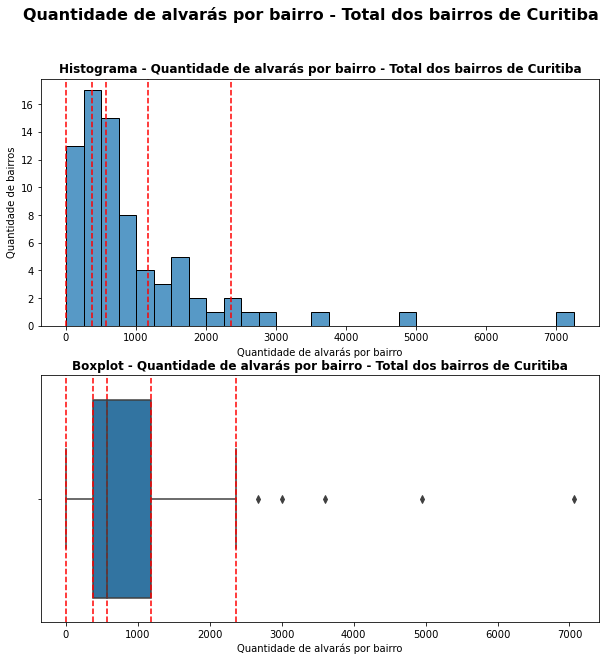

In [47]:
fig_qt_bairros = plt.figure(figsize = (10, 10))

plt.suptitle('Quantidade de alvarás por bairro - Total dos bairros de Curitiba', fontsize = 16, fontweight = 'bold')

ax1 = plt.subplot(211)
sns.histplot(data = df_por_bairro_por_ativ, x = 'por_bairro', binwidth = 250, ax = ax1)
plt.title('Histograma - Quantidade de alvarás por bairro - Total dos bairros de Curitiba', fontsize = 12, fontweight = 'bold')
plt.axvline(x = Limites_Boxplot(df_por_bairro_por_ativ.por_bairro)[0], color = 'red', linestyle = 'dashed')
plt.axvline(x = Limites_Boxplot(df_por_bairro_por_ativ.por_bairro)[1], color = 'red', linestyle = 'dashed')
plt.axvline(x = Limites_Boxplot(df_por_bairro_por_ativ.por_bairro)[2], color = 'red', linestyle = 'dashed')
plt.axvline(x = Limites_Boxplot(df_por_bairro_por_ativ.por_bairro)[3], color = 'red', linestyle = 'dashed')
plt.axvline(x = Limites_Boxplot(df_por_bairro_por_ativ.por_bairro)[4], color = 'red', linestyle = 'dashed')
plt.xlabel('Quantidade de alvarás por bairro')
plt.ylabel('Quantidade de bairros');

ax2 = plt.subplot(212)
sns.boxplot(data = df_por_bairro_por_ativ, x = 'por_bairro', ax = ax2)
plt.title('Boxplot - Quantidade de alvarás por bairro - Total dos bairros de Curitiba', fontsize = 12, fontweight = 'bold')
plt.axvline(x = Limites_Boxplot(df_por_bairro_por_ativ.por_bairro)[0], color = 'red', linestyle = 'dashed')
plt.axvline(x = Limites_Boxplot(df_por_bairro_por_ativ.por_bairro)[1], color = 'red', linestyle = 'dashed')
plt.axvline(x = Limites_Boxplot(df_por_bairro_por_ativ.por_bairro)[2], color = 'red', linestyle = 'dashed')
plt.axvline(x = Limites_Boxplot(df_por_bairro_por_ativ.por_bairro)[3], color = 'red', linestyle = 'dashed')
plt.axvline(x = Limites_Boxplot(df_por_bairro_por_ativ.por_bairro)[4], color = 'red', linestyle = 'dashed')
plt.xlabel('Quantidade de alvarás por bairro');

In [48]:
# Como é um resumo dos valores?
DataFrame_Resumo_Boxplot(df_por_bairro_por_ativ.por_bairro)

,Whisker inferior,1-quartil,Mediana,3-quartil,Whisker superior,Quant out abaixo,Quant out acima
0,5.0,370.0,575.0,1177.0,2358.0,0.0,5.0


In [49]:
# Quais são os bairros que representam outliers acima, em quantidade de alvarás?
df_por_bairro_por_ativ.loc[df_por_bairro_por_ativ.por_bairro > Limites_Boxplot(df_por_bairro_por_ativ.por_bairro)[4]]

,bairro,por_bairro,Hs_ativ_usar
0,CENTRO,7057,3.780805
1,CIDADE INDUSTRIAL DE CURITIBA,4943,3.531372
2,BOQUEIRÃO,3598,3.361095
3,SÍTIO CERCADO,3000,3.217931
4,ÁGUA VERDE,2676,3.747951


#### Como está distribuída a Entropia de Shannon entre os bairros?

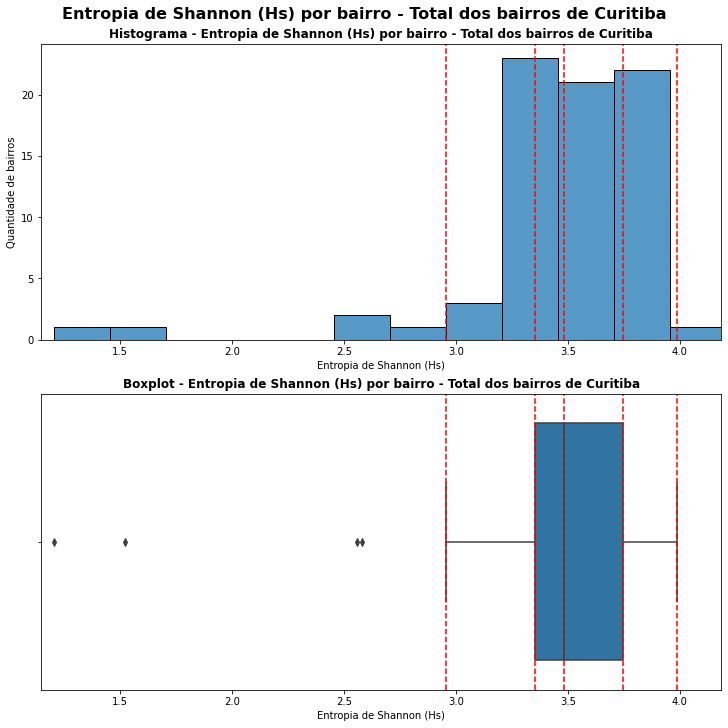

In [50]:
fig_hs_bairros = plt.figure(figsize = (10,10), constrained_layout=True)

plt.suptitle('Entropia de Shannon (Hs) por bairro - Total dos bairros de Curitiba', fontsize = 16, fontweight = 'bold')

ax1 = plt.subplot(211)
sns.histplot(data = df_por_bairro_por_ativ, x = 'Hs_ativ_usar', binwidth = .25, ax = ax1)
plt.title('Histograma - Entropia de Shannon (Hs) por bairro - Total dos bairros de Curitiba', fontsize = 12, fontweight = 'bold')
plt.axvline(x = Limites_Boxplot(df_por_bairro_por_ativ.Hs_ativ_usar)[0], color = 'red', linestyle = 'dashed')
plt.axvline(x = Limites_Boxplot(df_por_bairro_por_ativ.Hs_ativ_usar)[1], color = 'red', linestyle = 'dashed')
plt.axvline(x = Limites_Boxplot(df_por_bairro_por_ativ.Hs_ativ_usar)[2], color = 'red', linestyle = 'dashed')
plt.axvline(x = Limites_Boxplot(df_por_bairro_por_ativ.Hs_ativ_usar)[3], color = 'red', linestyle = 'dashed')
plt.axvline(x = Limites_Boxplot(df_por_bairro_por_ativ.Hs_ativ_usar)[4], color = 'red', linestyle = 'dashed')
plt.xlim(0.95 * min(df_por_bairro_por_ativ.Hs_ativ_usar), 1.05 * max(df_por_bairro_por_ativ.Hs_ativ_usar))
plt.xlabel('Entropia de Shannon (Hs)')
plt.ylabel('Quantidade de bairros');

ax2 = plt.subplot(212)
sns.boxplot(data = df_por_bairro_por_ativ, x = 'Hs_ativ_usar', ax = ax2)
plt.title('Boxplot - Entropia de Shannon (Hs) por bairro - Total dos bairros de Curitiba', fontsize = 12, fontweight = 'bold')
plt.axvline(x = Limites_Boxplot(df_por_bairro_por_ativ.Hs_ativ_usar)[0], color = 'red', linestyle = 'dashed')
plt.axvline(x = Limites_Boxplot(df_por_bairro_por_ativ.Hs_ativ_usar)[1], color = 'red', linestyle = 'dashed')
plt.axvline(x = Limites_Boxplot(df_por_bairro_por_ativ.Hs_ativ_usar)[2], color = 'red', linestyle = 'dashed')
plt.axvline(x = Limites_Boxplot(df_por_bairro_por_ativ.Hs_ativ_usar)[3], color = 'red', linestyle = 'dashed')
plt.axvline(x = Limites_Boxplot(df_por_bairro_por_ativ.Hs_ativ_usar)[4], color = 'red', linestyle = 'dashed')
plt.xlim(0.95 * min(df_por_bairro_por_ativ.Hs_ativ_usar), 1.05 * max(df_por_bairro_por_ativ.Hs_ativ_usar))
plt.xlabel('Entropia de Shannon (Hs)');

In [51]:
# Qual é a ordem dos bairros, conforme o valor de Hs?
df_por_bairro_por_ativ.sort_values(by = 'Hs_ativ_usar', ascending = True).reset_index(drop=True).style

,bairro,por_bairro,Hs_ativ_usar
0,SÃO MIGUEL,12,1.207519
1,RIVIERA,5,1.521928
2,CAXIMBA,29,2.558980
3,CASCATINHA,93,2.581274
4,SÃO JOÃO,66,2.954162
5,AUGUSTA,83,3.080722
6,TATUQUARA,1172,3.185049
7,CAMPO DE SANTANA,575,3.187538
8,SÍTIO CERCADO,3000,3.217931
9,LINDÓIA,171,3.248489


In [52]:
# Como é um resumo dos valores?
DataFrame_Resumo_Boxplot(df_por_bairro_por_ativ.Hs_ativ_usar)

,Whisker inferior,1-quartil,Mediana,3-quartil,Whisker superior,Quant out abaixo,Quant out acima
0,2.954162,3.354777,3.482613,3.747578,3.985834,4.0,0.0


In [53]:
# Quais são os bairros que representam outliers abaixo, em Entropia de Shannon? (maiores concentrações)
df_por_bairro_por_ativ.loc[df_por_bairro_por_ativ.Hs_ativ_usar < Limites_Boxplot(df_por_bairro_por_ativ.Hs_ativ_usar)[0]].sort_values(by = 'Hs_ativ_usar', ascending = True)

,bairro,por_bairro,Hs_ativ_usar
73,SÃO MIGUEL,12,1.207519
74,RIVIERA,5,1.521928
72,CAXIMBA,29,2.558980
67,CASCATINHA,93,2.581274


#### Como ficaria a representação cartográfica da distribuição de Shannon para todos os bairros de Curitiba, quando comparada com a quantidade de alvarás por bairro?

In [54]:
mapa_hs_bairros = gpd.GeoDataFrame(pd.merge(df_por_bairro_por_ativ, gdf_mapa_bairros.iloc[:,[2,6]], how = 'left', left_on = 'bairro', right_on = 'nome').drop(columns = {'nome'}).sort_values(by = 'Hs_ativ_usar').reset_index(drop=True))
mapa_hs_bairros = mapa_hs_bairros.rename(columns = {'geom':'geometry'})

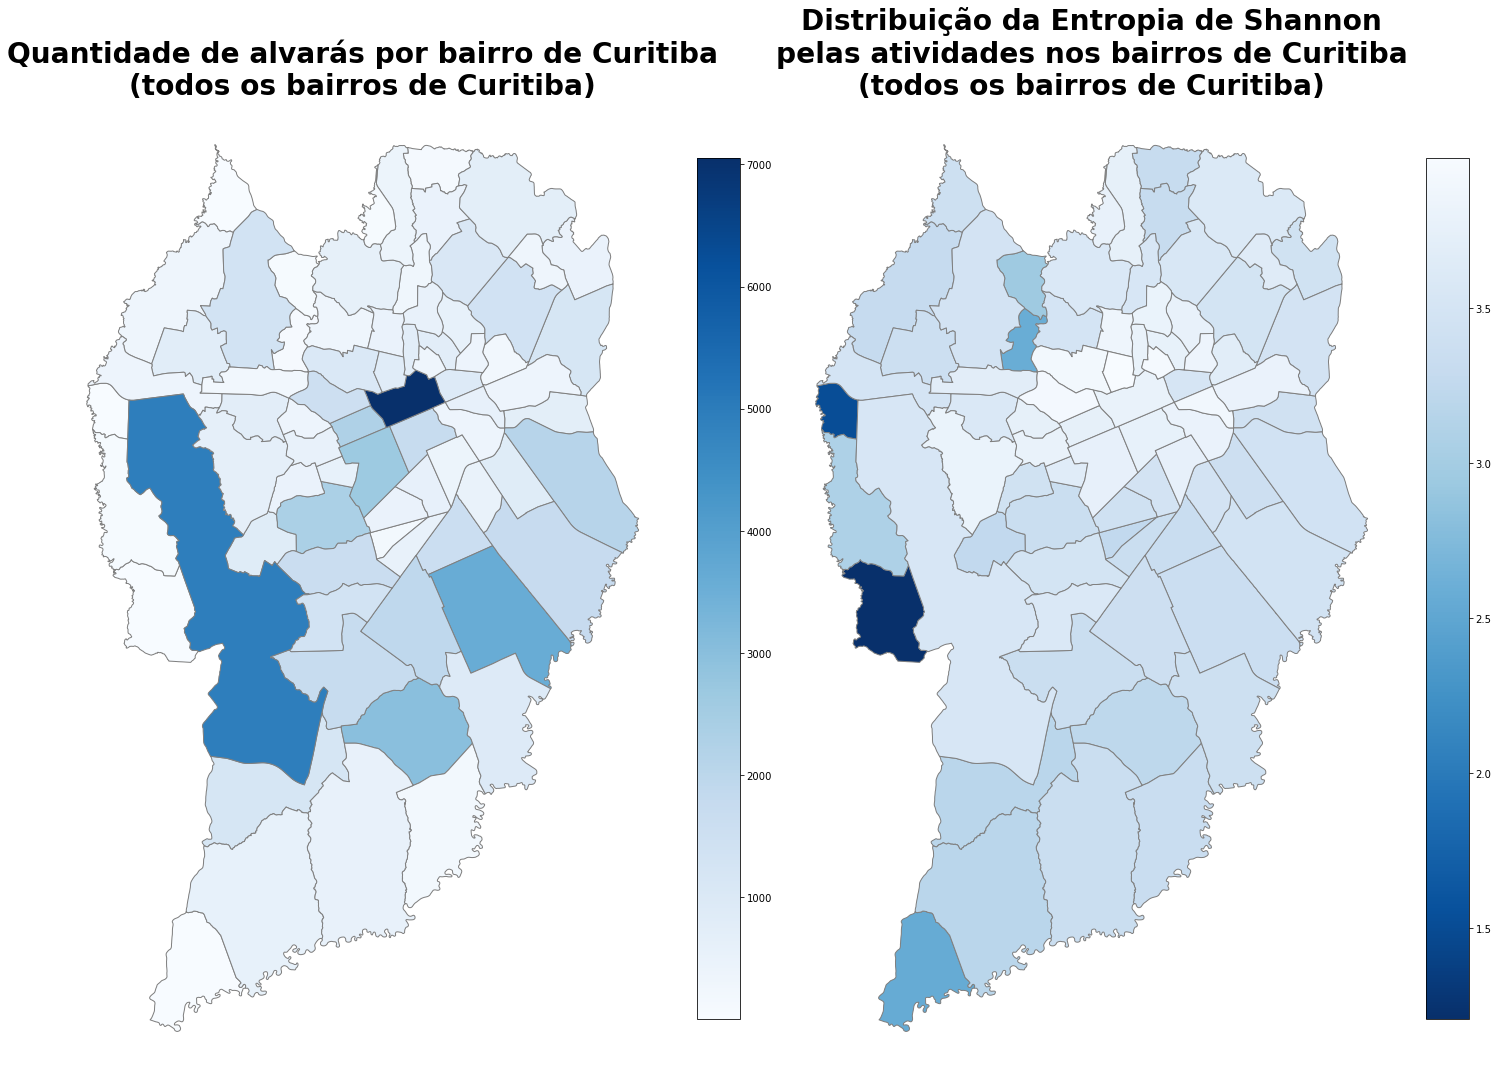

In [55]:
# PLOTAGEM DOS MAPAS LADO A LADO
from matplotlib.gridspec import GridSpec
fig = plt.figure(figsize=(20, 24), constrained_layout=True)

specs = GridSpec(ncols=2, nrows=1, figure=fig)

ax1 = fig.add_subplot(specs[0, 0])
mapa_hs_bairros.plot(ax = gdf_mapa_bairros.plot(ax=ax1, color = 'lightgray'), column = 'por_bairro', edgecolor='gray', cmap='Blues', legend = True, legend_kwds = {'shrink':.5})
plt.title('Quantidade de alvarás por bairro de Curitiba\n(todos os bairros de Curitiba)', fontsize = 28, fontweight = 'bold');
plt.axis('off');

ax2 = fig.add_subplot(specs[0, 1])
mapa_hs_bairros.plot(ax = gdf_mapa_bairros.plot(ax=ax2, color = 'lightgray'), column = 'Hs_ativ_usar', edgecolor='gray', cmap='Blues_r', legend = True, legend_kwds = {'shrink':.5})
plt.title('Distribuição da Entropia de Shannon\npelas atividades nos bairros de Curitiba\n(todos os bairros de Curitiba)', fontsize = 28, fontweight = 'bold');
plt.axis('off');

Um dos objetivos deste levantamento é buscar locais de Curitiba onde possa haver uma vocação econômica específica, ou seja, grande quantidade de estabelecimentos cuja atividade seja igual. Com isso, pode-se aqui estabelecer 2 critérios para esse tipo de local:<br>
1. Alta quantidade de alvarás: o critério que será usado é "estar acima da mediana" das quantidades
2. Alta concentração: o critério que será usado é "estar abaixo da mediana" da Entropia de Shannon

Como ficaria essa distribuição das entropias de Shannon, levando-se em conta apenas os bairros cuja quantidade de alvarás está acima da mediana da cidade de Curitiba?

In [56]:
df_por_bairro_por_ativ_alta_qt = df_por_bairro_por_ativ.loc[df_por_bairro_por_ativ.por_bairro > Limites_Boxplot(df_por_bairro_por_ativ.por_bairro)[2]].reset_index(drop = True)

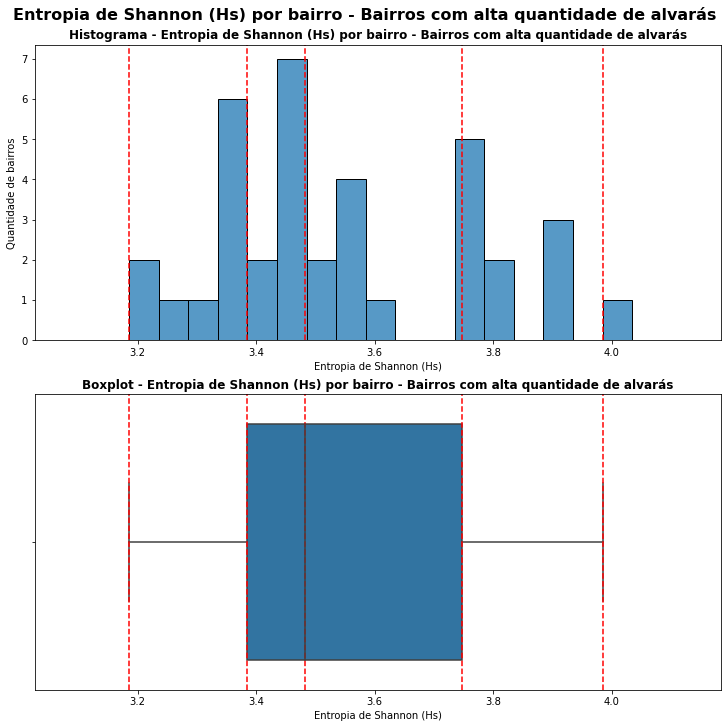

In [57]:
fig_hs_bairros_alta_qt = plt.figure(figsize = (10,10), constrained_layout=True)

plt.suptitle('Entropia de Shannon (Hs) por bairro - Bairros com alta quantidade de alvarás', fontsize = 16, fontweight = 'bold')

ax1 = plt.subplot(211)
sns.histplot(data = df_por_bairro_por_ativ_alta_qt, x = 'Hs_ativ_usar', binwidth = .05, ax = ax1)
plt.title('Histograma - Entropia de Shannon (Hs) por bairro - Bairros com alta quantidade de alvarás', fontsize = 12, fontweight = 'bold')
plt.axvline(x = Limites_Boxplot(df_por_bairro_por_ativ_alta_qt.Hs_ativ_usar)[0], color = 'red', linestyle = 'dashed')
plt.axvline(x = Limites_Boxplot(df_por_bairro_por_ativ_alta_qt.Hs_ativ_usar)[1], color = 'red', linestyle = 'dashed')
plt.axvline(x = Limites_Boxplot(df_por_bairro_por_ativ_alta_qt.Hs_ativ_usar)[2], color = 'red', linestyle = 'dashed')
plt.axvline(x = Limites_Boxplot(df_por_bairro_por_ativ_alta_qt.Hs_ativ_usar)[3], color = 'red', linestyle = 'dashed')
plt.axvline(x = Limites_Boxplot(df_por_bairro_por_ativ_alta_qt.Hs_ativ_usar)[4], color = 'red', linestyle = 'dashed')
plt.xlim(0.95 * min(df_por_bairro_por_ativ_alta_qt.Hs_ativ_usar), 1.05 * max(df_por_bairro_por_ativ_alta_qt.Hs_ativ_usar))
plt.xlabel('Entropia de Shannon (Hs)')
plt.ylabel('Quantidade de bairros');

ax2 = plt.subplot(212)
sns.boxplot(data = df_por_bairro_por_ativ_alta_qt, x = 'Hs_ativ_usar', ax = ax2)
plt.title('Boxplot - Entropia de Shannon (Hs) por bairro - Bairros com alta quantidade de alvarás', fontsize = 12, fontweight = 'bold')
plt.axvline(x = Limites_Boxplot(df_por_bairro_por_ativ_alta_qt.Hs_ativ_usar)[0], color = 'red', linestyle = 'dashed')
plt.axvline(x = Limites_Boxplot(df_por_bairro_por_ativ_alta_qt.Hs_ativ_usar)[1], color = 'red', linestyle = 'dashed')
plt.axvline(x = Limites_Boxplot(df_por_bairro_por_ativ_alta_qt.Hs_ativ_usar)[2], color = 'red', linestyle = 'dashed')
plt.axvline(x = Limites_Boxplot(df_por_bairro_por_ativ_alta_qt.Hs_ativ_usar)[3], color = 'red', linestyle = 'dashed')
plt.axvline(x = Limites_Boxplot(df_por_bairro_por_ativ_alta_qt.Hs_ativ_usar)[4], color = 'red', linestyle = 'dashed')
plt.xlim(0.95 * min(df_por_bairro_por_ativ_alta_qt.Hs_ativ_usar), 1.05 * max(df_por_bairro_por_ativ_alta_qt.Hs_ativ_usar))
plt.xlabel('Entropia de Shannon (Hs)');

In [58]:
# Como é um resumo dos valores?
DataFrame_Resumo_Boxplot(df_por_bairro_por_ativ_alta_qt.Hs_ativ_usar)

,Whisker inferior,1-quartil,Mediana,3-quartil,Whisker superior,Quant out abaixo,Quant out acima
0,3.185049,3.384423,3.482613,3.747951,3.985834,0.0,0.0


In [59]:
# Quais são os bairros que representam as maiores concentrações, estando abaixo da mediana?
mediana_hs_alta_qt = Limites_Boxplot(df_por_bairro_por_ativ_alta_qt.Hs_ativ_usar)[2]
qt_abaixo = len(df_por_bairro_por_ativ_alta_qt.loc[df_por_bairro_por_ativ_alta_qt.Hs_ativ_usar < mediana_hs_alta_qt])
print(f'São os {qt_abaixo} seguintes bairros:')
df_mais_conc_alta_qt = df_por_bairro_por_ativ_alta_qt.loc[df_por_bairro_por_ativ_alta_qt.Hs_ativ_usar < mediana_hs_alta_qt].sort_values(by = 'Hs_ativ_usar').reset_index(drop = True)
df_mais_conc_alta_qt

São os 18 seguintes bairros:


,bairro,por_bairro,Hs_ativ_usar
0,TATUQUARA,1172,3.185049
1,SÍTIO CERCADO,3000,3.217931
2,FAZENDINHA,834,3.253300
3,HAUER,1581,3.330816
4,PORTÃO,2358,3.353211
5,PINHEIRINHO,1724,3.354593
6,BOQUEIRÃO,3598,3.361095
7,SÃO BRAZ,782,3.377874
8,JARDIM DAS AMÉRICAS,837,3.378296
9,XAXIM,1920,3.384423


#### Como ficaria a representação cartográfica da distribuição de Shannon para todos os bairros de Curitiba, quando comparada com a quantidade de alvarás por bairro? (mas apenas para os bairros com maior quantidade de alvarás)

In [60]:
mapa_hs_bairros_alta_qt = mapa_hs_bairros.copy()
mapa_hs_bairros_alta_qt.loc[mapa_hs_bairros_alta_qt.por_bairro < np.median(mapa_hs_bairros_alta_qt.por_bairro), 'Hs_ativ_usar'] = np.nan

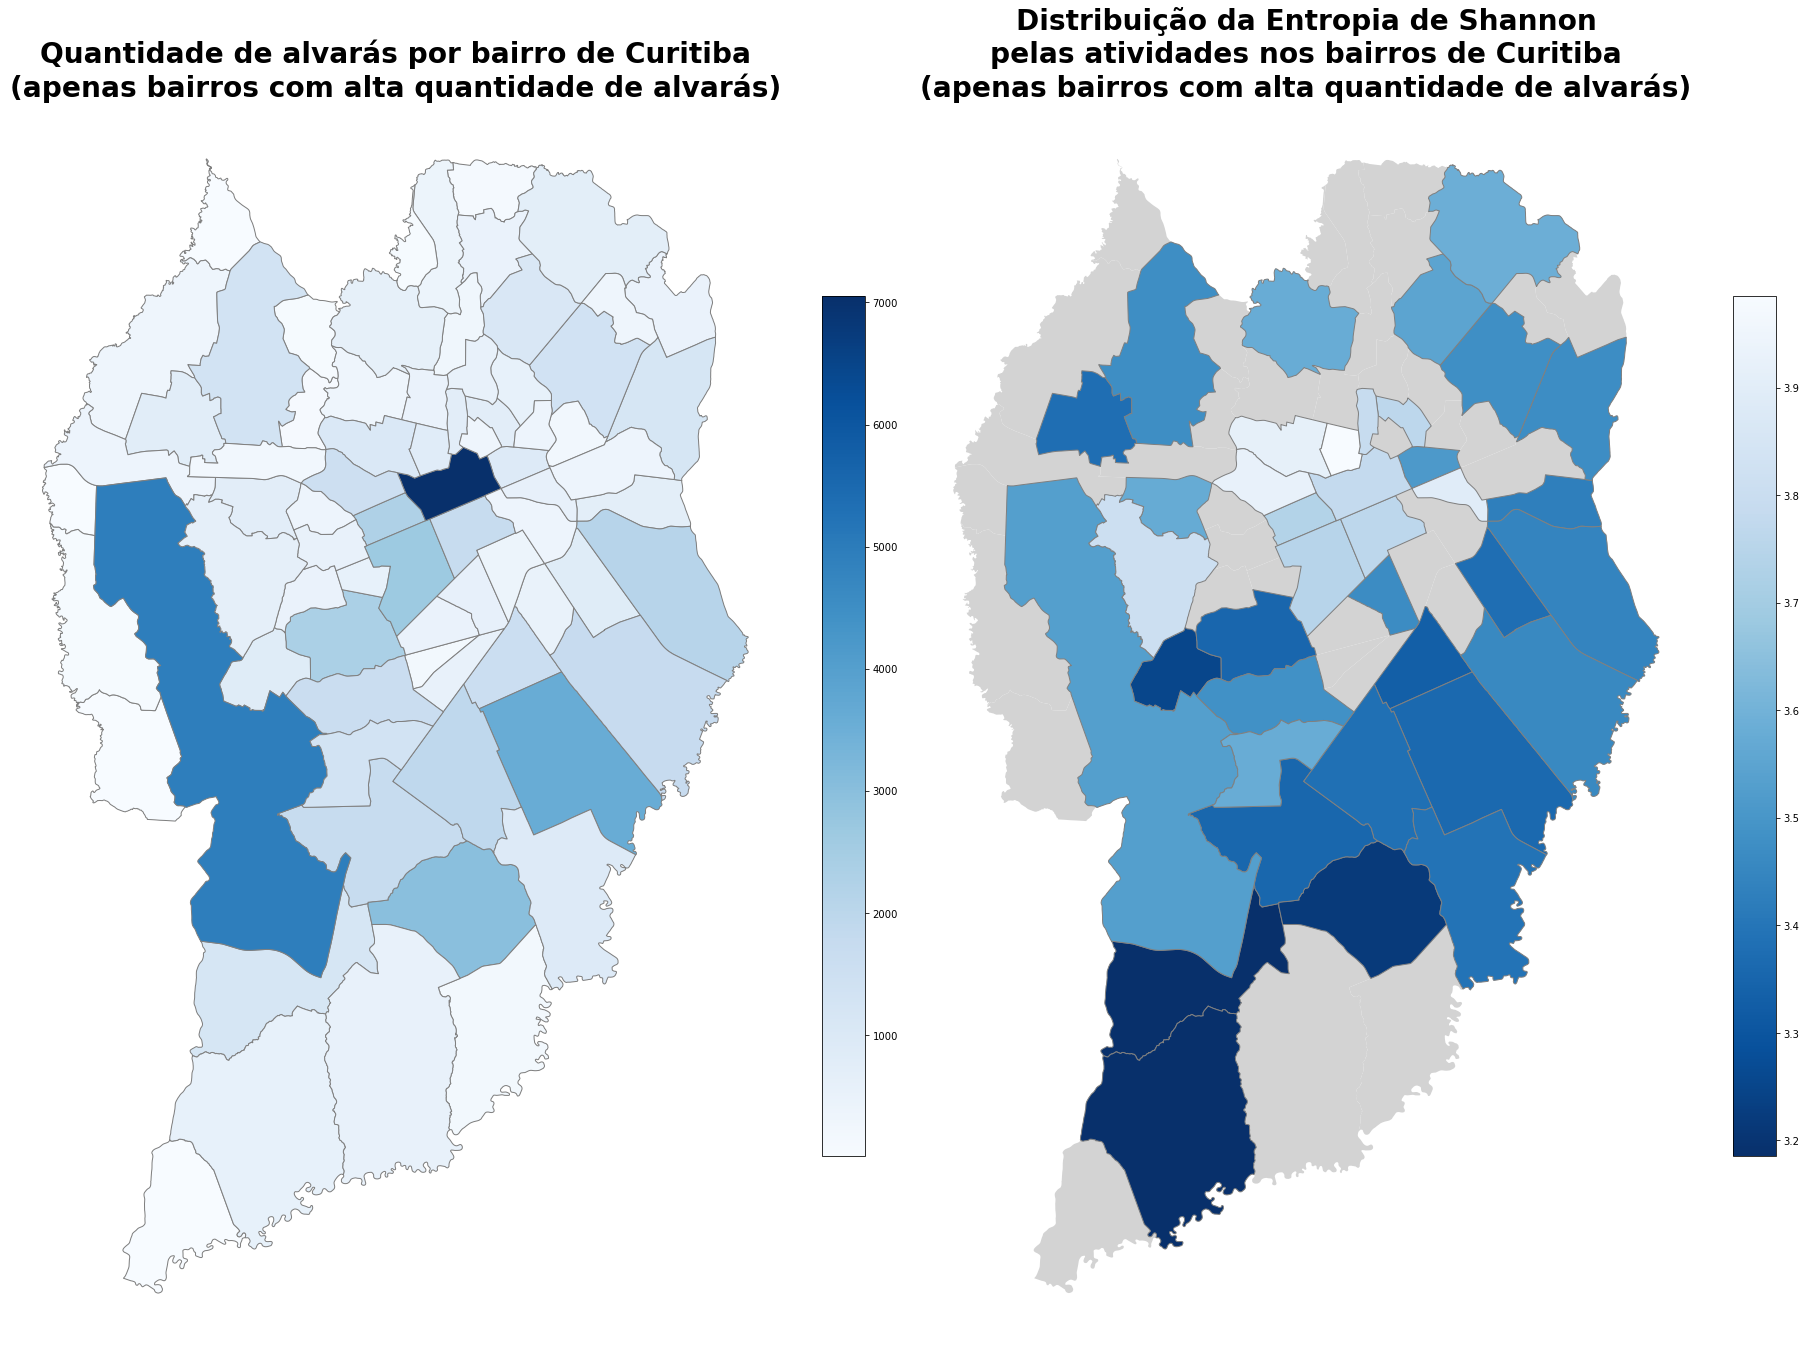

In [61]:
# PLOTAGEM DOS MAPAS LADO A LADO
from matplotlib.gridspec import GridSpec
fig = plt.figure(figsize=(25, 24), constrained_layout=True)

specs = GridSpec(ncols=2, nrows=1, figure=fig)

ax1 = fig.add_subplot(specs[0, 0])
mapa_hs_bairros_alta_qt.plot(ax = gdf_mapa_bairros.plot(ax=ax1, color = 'lightgray'), column = 'por_bairro', edgecolor='gray', cmap='Blues', legend = True, legend_kwds = {'shrink':.5})
plt.title('Quantidade de alvarás por bairro de Curitiba\n(apenas bairros com alta quantidade de alvarás)', fontsize = 28, fontweight = 'bold');
plt.axis('off');

ax2 = fig.add_subplot(specs[0, 1])
mapa_hs_bairros_alta_qt.plot(ax = gdf_mapa_bairros.plot(ax=ax2, color = 'lightgray'), column = 'Hs_ativ_usar', edgecolor='gray', cmap='Blues_r', legend = True, legend_kwds = {'shrink':.5})
plt.title('Distribuição da Entropia de Shannon\npelas atividades nos bairros de Curitiba\n(apenas bairros com alta quantidade de alvarás)', fontsize = 28, fontweight = 'bold');
plt.axis('off');

### Como fica a mesma análise, mas com base em 'atividade_principal' ? (original da Prefeitura)

#### Como está distribuída a nova Entropia de Shannon entre os bairros?

In [62]:
# Novo cálculo das Entropias de Shannon
df_por_bairro_por_ativ_princ = df_por_bairro.copy().iloc[:,[0,1]]
df_por_bairro_por_ativ_princ['Hs_ativ_princ'] = df_por_bairro_por_ativ_princ.apply(lambda x: Entropia_Shannon_Bairro('atividade_principal', x['bairro'], df_geral = df_alvaras), axis = 1)

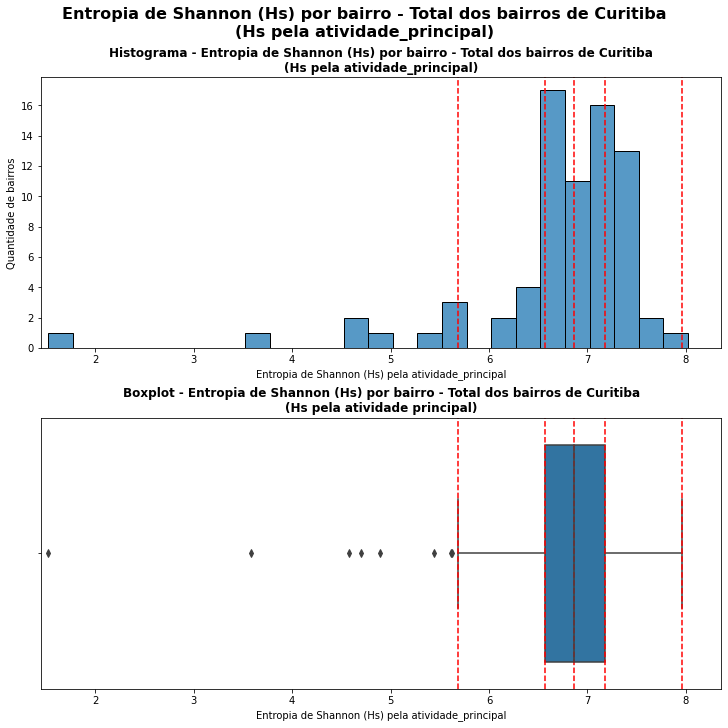

In [63]:
fig_hs_bairros_princ = plt.figure(figsize = (10,10), constrained_layout=True)

plt.suptitle('Entropia de Shannon (Hs) por bairro - Total dos bairros de Curitiba\n(Hs pela atividade_principal)', fontsize = 16, fontweight = 'bold')

ax1 = plt.subplot(211)
sns.histplot(data = df_por_bairro_por_ativ_princ, x = 'Hs_ativ_princ', binwidth = .25, ax = ax1)
plt.title('Histograma - Entropia de Shannon (Hs) por bairro - Total dos bairros de Curitiba\n(Hs pela atividade_principal)', fontsize = 12, fontweight = 'bold')
plt.axvline(x = Limites_Boxplot(df_por_bairro_por_ativ_princ.Hs_ativ_princ)[0], color = 'red', linestyle = 'dashed')
plt.axvline(x = Limites_Boxplot(df_por_bairro_por_ativ_princ.Hs_ativ_princ)[1], color = 'red', linestyle = 'dashed')
plt.axvline(x = Limites_Boxplot(df_por_bairro_por_ativ_princ.Hs_ativ_princ)[2], color = 'red', linestyle = 'dashed')
plt.axvline(x = Limites_Boxplot(df_por_bairro_por_ativ_princ.Hs_ativ_princ)[3], color = 'red', linestyle = 'dashed')
plt.axvline(x = Limites_Boxplot(df_por_bairro_por_ativ_princ.Hs_ativ_princ)[4], color = 'red', linestyle = 'dashed')
plt.xlim(0.95 * min(df_por_bairro_por_ativ_princ.Hs_ativ_princ), 1.05 * max(df_por_bairro_por_ativ_princ.Hs_ativ_princ))
plt.xlabel('Entropia de Shannon (Hs) pela atividade_principal')
plt.ylabel('Quantidade de bairros');

ax2 = plt.subplot(212)
sns.boxplot(data = df_por_bairro_por_ativ_princ, x = 'Hs_ativ_princ', ax = ax2)
plt.title('Boxplot - Entropia de Shannon (Hs) por bairro - Total dos bairros de Curitiba\n(Hs pela atividade principal)', fontsize = 12, fontweight = 'bold')
plt.axvline(x = Limites_Boxplot(df_por_bairro_por_ativ_princ.Hs_ativ_princ)[0], color = 'red', linestyle = 'dashed')
plt.axvline(x = Limites_Boxplot(df_por_bairro_por_ativ_princ.Hs_ativ_princ)[1], color = 'red', linestyle = 'dashed')
plt.axvline(x = Limites_Boxplot(df_por_bairro_por_ativ_princ.Hs_ativ_princ)[2], color = 'red', linestyle = 'dashed')
plt.axvline(x = Limites_Boxplot(df_por_bairro_por_ativ_princ.Hs_ativ_princ)[3], color = 'red', linestyle = 'dashed')
plt.axvline(x = Limites_Boxplot(df_por_bairro_por_ativ_princ.Hs_ativ_princ)[4], color = 'red', linestyle = 'dashed')
plt.xlim(0.95 * min(df_por_bairro_por_ativ_princ.Hs_ativ_princ), 1.05 * max(df_por_bairro_por_ativ_princ.Hs_ativ_princ))
plt.xlabel('Entropia de Shannon (Hs) pela atividade_principal');

In [64]:
# Como é um resumo dos valores?
DataFrame_Resumo_Boxplot(df_por_bairro_por_ativ_princ.Hs_ativ_princ)

,Whisker inferior,1-quartil,Mediana,3-quartil,Whisker superior,Quant out abaixo,Quant out acima
0,5.681881,6.571317,6.860482,7.182609,7.962539,8.0,0.0


In [65]:
# Quais são os bairros que representam outliers abaixo, em Entropia de Shannon? (maiores concentrações)
df_por_bairro_por_ativ_princ.loc[df_por_bairro_por_ativ_princ.Hs_ativ_princ < Limites_Boxplot(df_por_bairro_por_ativ_princ.Hs_ativ_princ)[0]].sort_values(by = 'Hs_ativ_princ', ascending = True)

,bairro,por_bairro,Hs_ativ_princ
74,RIVIERA,5,1.521928
73,SÃO MIGUEL,12,3.584963
72,CAXIMBA,29,4.582119
71,LAMENHA PEQUENA,31,4.696132
67,CASCATINHA,93,4.887479
68,AUGUSTA,83,5.442197
66,CACHOEIRA,141,5.613694
70,SÃO JOÃO,66,5.627579


#### Como ficaria a nova representação cartográfica da distribuição de Shannon para todos os bairros de Curitiba, quando comparada com a quantidade de alvarás por bairro?

In [66]:
mapa_hs_bairros_ativ_princ = gpd.GeoDataFrame(pd.merge(df_por_bairro_por_ativ_princ, gdf_mapa_bairros.iloc[:,[2,6]], how = 'left', left_on = 'bairro', right_on = 'nome').drop(columns = {'nome'}).sort_values(by = 'Hs_ativ_princ').reset_index(drop=True))
mapa_hs_bairros_ativ_princ = mapa_hs_bairros_ativ_princ.rename(columns = {'geom':'geometry'})

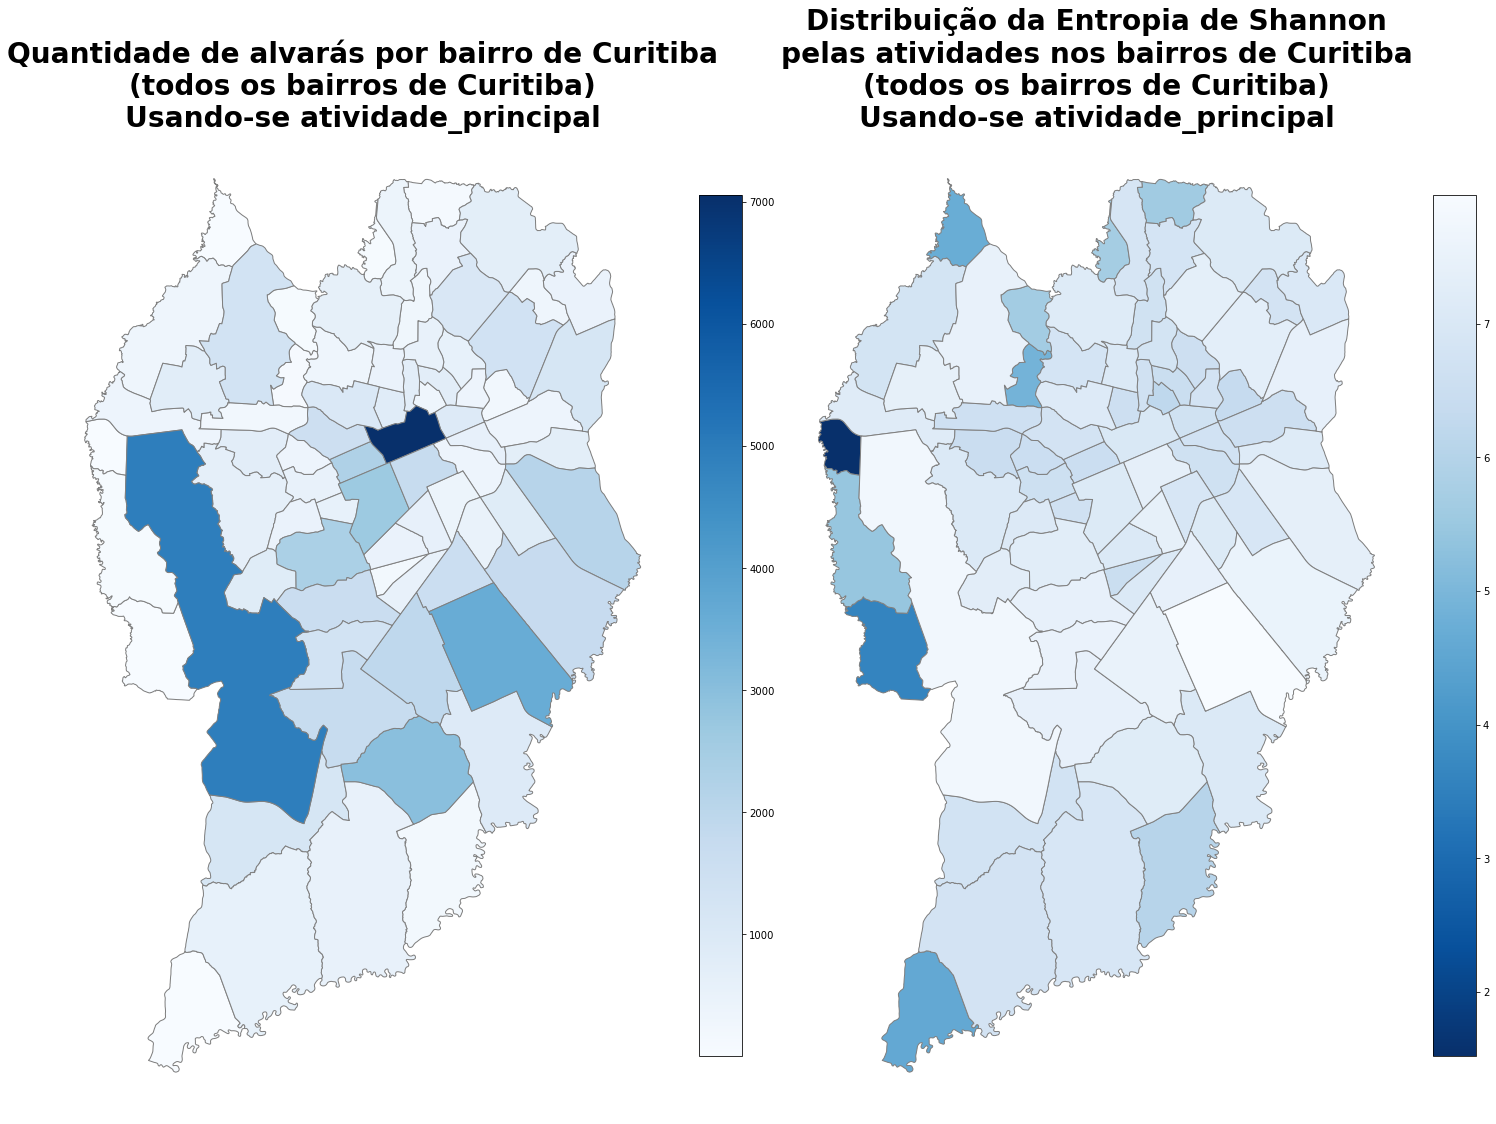

In [67]:
# PLOTAGEM DOS MAPAS LADO A LADO
from matplotlib.gridspec import GridSpec
fig = plt.figure(figsize=(20, 24), constrained_layout=True)

specs = GridSpec(ncols=2, nrows=1, figure=fig)

ax1 = fig.add_subplot(specs[0, 0])
mapa_hs_bairros_ativ_princ.plot(ax = gdf_mapa_bairros.plot(ax=ax1, color = 'lightgray'), column = 'por_bairro', edgecolor='gray', cmap='Blues', legend = True, legend_kwds = {'shrink':.5})
plt.title('Quantidade de alvarás por bairro de Curitiba\n(todos os bairros de Curitiba)\nUsando-se atividade_principal', fontsize = 28, fontweight = 'bold');
plt.axis('off');

ax2 = fig.add_subplot(specs[0, 1])
mapa_hs_bairros_ativ_princ.plot(ax = gdf_mapa_bairros.plot(ax=ax2, color = 'lightgray'), column = 'Hs_ativ_princ', edgecolor='gray', cmap='Blues_r', legend = True, legend_kwds = {'shrink':.5})
plt.title('Distribuição da Entropia de Shannon\npelas atividades nos bairros de Curitiba\n(todos os bairros de Curitiba)\nUsando-se atividade_principal', fontsize = 28, fontweight = 'bold');
plt.axis('off');

Como ficaria essa distribuição das entropias de Shannon, levando-se em conta apenas os bairros cuja quantidade de alvarás está acima da mediana da cidade de Curitiba?

In [68]:
df_por_bairro_por_ativ_princ_alta_qt = df_por_bairro_por_ativ_princ.loc[df_por_bairro_por_ativ_princ.por_bairro > Limites_Boxplot(df_por_bairro_por_ativ_princ.por_bairro)[2]].reset_index(drop = True)

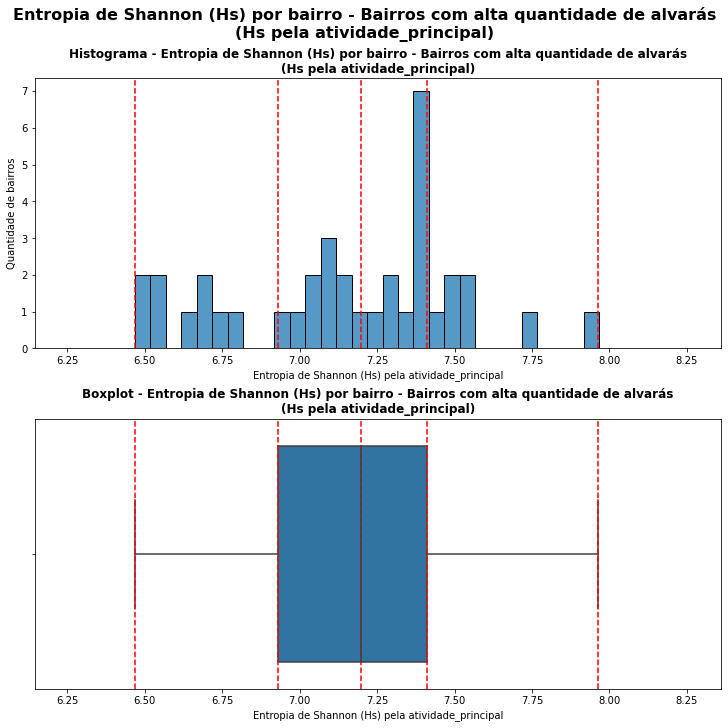

In [69]:
fig_hs_bairros_alta_qt_at_p = plt.figure(figsize = (10,10), constrained_layout=True)

plt.suptitle('Entropia de Shannon (Hs) por bairro - Bairros com alta quantidade de alvarás\n(Hs pela atividade_principal)', fontsize = 16, fontweight = 'bold')

ax1 = plt.subplot(211)
sns.histplot(data = df_por_bairro_por_ativ_princ_alta_qt, x = 'Hs_ativ_princ', binwidth = .05, ax = ax1)
plt.title('Histograma - Entropia de Shannon (Hs) por bairro - Bairros com alta quantidade de alvarás\n(Hs pela atividade_principal)', fontsize = 12, fontweight = 'bold')
plt.axvline(x = Limites_Boxplot(df_por_bairro_por_ativ_princ_alta_qt.Hs_ativ_princ)[0], color = 'red', linestyle = 'dashed')
plt.axvline(x = Limites_Boxplot(df_por_bairro_por_ativ_princ_alta_qt.Hs_ativ_princ)[1], color = 'red', linestyle = 'dashed')
plt.axvline(x = Limites_Boxplot(df_por_bairro_por_ativ_princ_alta_qt.Hs_ativ_princ)[2], color = 'red', linestyle = 'dashed')
plt.axvline(x = Limites_Boxplot(df_por_bairro_por_ativ_princ_alta_qt.Hs_ativ_princ)[3], color = 'red', linestyle = 'dashed')
plt.axvline(x = Limites_Boxplot(df_por_bairro_por_ativ_princ_alta_qt.Hs_ativ_princ)[4], color = 'red', linestyle = 'dashed')
plt.xlim(0.95 * min(df_por_bairro_por_ativ_princ_alta_qt.Hs_ativ_princ), 1.05 * max(df_por_bairro_por_ativ_princ_alta_qt.Hs_ativ_princ))
plt.xlabel('Entropia de Shannon (Hs) pela atividade_principal')
plt.ylabel('Quantidade de bairros');

ax2 = plt.subplot(212)
sns.boxplot(data = df_por_bairro_por_ativ_princ_alta_qt, x = 'Hs_ativ_princ', ax = ax2)
plt.title('Boxplot - Entropia de Shannon (Hs) por bairro - Bairros com alta quantidade de alvarás\n(Hs pela atividade_principal)', fontsize = 12, fontweight = 'bold')
plt.axvline(x = Limites_Boxplot(df_por_bairro_por_ativ_princ_alta_qt.Hs_ativ_princ)[0], color = 'red', linestyle = 'dashed')
plt.axvline(x = Limites_Boxplot(df_por_bairro_por_ativ_princ_alta_qt.Hs_ativ_princ)[1], color = 'red', linestyle = 'dashed')
plt.axvline(x = Limites_Boxplot(df_por_bairro_por_ativ_princ_alta_qt.Hs_ativ_princ)[2], color = 'red', linestyle = 'dashed')
plt.axvline(x = Limites_Boxplot(df_por_bairro_por_ativ_princ_alta_qt.Hs_ativ_princ)[3], color = 'red', linestyle = 'dashed')
plt.axvline(x = Limites_Boxplot(df_por_bairro_por_ativ_princ_alta_qt.Hs_ativ_princ)[4], color = 'red', linestyle = 'dashed')
plt.xlim(0.95 * min(df_por_bairro_por_ativ_princ_alta_qt.Hs_ativ_princ), 1.05 * max(df_por_bairro_por_ativ_princ_alta_qt.Hs_ativ_princ))
plt.xlabel('Entropia de Shannon (Hs) pela atividade_principal');

In [70]:
# Como é um resumo dos valores?
DataFrame_Resumo_Boxplot(df_por_bairro_por_ativ_princ_alta_qt.Hs_ativ_princ)

,Whisker inferior,1-quartil,Mediana,3-quartil,Whisker superior,Quant out abaixo,Quant out acima
0,6.467104,6.930954,7.198926,7.410893,7.962539,0.0,0.0


In [71]:
# Quais são os bairros que representam as maiores concentrações, estando abaixo da mediana?
mediana_hs_alta_qt_at_princ = Limites_Boxplot(df_por_bairro_por_ativ_princ_alta_qt.Hs_ativ_princ)[2]
qt_abaixo_at_princ = len(df_por_bairro_por_ativ_princ_alta_qt.loc[df_por_bairro_por_ativ_princ_alta_qt.Hs_ativ_princ < mediana_hs_alta_qt_at_princ])
print(f'São os {qt_abaixo_at_princ} seguintes bairros:')
df_mais_conc_alta_qt_at_princ = df_por_bairro_por_ativ_princ_alta_qt.loc[df_por_bairro_por_ativ_princ_alta_qt.Hs_ativ_princ < mediana_hs_alta_qt_at_princ].sort_values(by = 'Hs_ativ_princ').reset_index(drop = True)
df_mais_conc_alta_qt_at_princ

São os 18 seguintes bairros:


,bairro,por_bairro,Hs_ativ_princ
0,MOSSUNGUÊ,749,6.467104
1,JUVEVÊ,768,6.481172
2,BATEL,2264,6.525205
3,SÃO FRANCISCO,820,6.564331
4,CENTRO CÍVICO,767,6.666869
5,ALTO DA RUA XV,925,6.681672
6,CRISTO REI,604,6.711981
7,TATUQUARA,1172,6.744552
8,BIGORRILHO,1534,6.771431
9,JARDIM DAS AMÉRICAS,837,6.930954


#### Como ficaria a representação cartográfica da distribuição de Shannon para todos os bairros de Curitiba, quando comparada com a quantidade de alvarás por bairro? (mas apenas para os bairros com maior quantidade de alvarás e a partir de atividade_principal)

In [72]:
mapa_hs_bairros_ativ_princ_alta_qt = mapa_hs_bairros_ativ_princ.copy()
mapa_hs_bairros_ativ_princ_alta_qt.loc[mapa_hs_bairros_ativ_princ_alta_qt.por_bairro < np.median(mapa_hs_bairros_ativ_princ_alta_qt.por_bairro), 'Hs_ativ_princ'] = np.nan

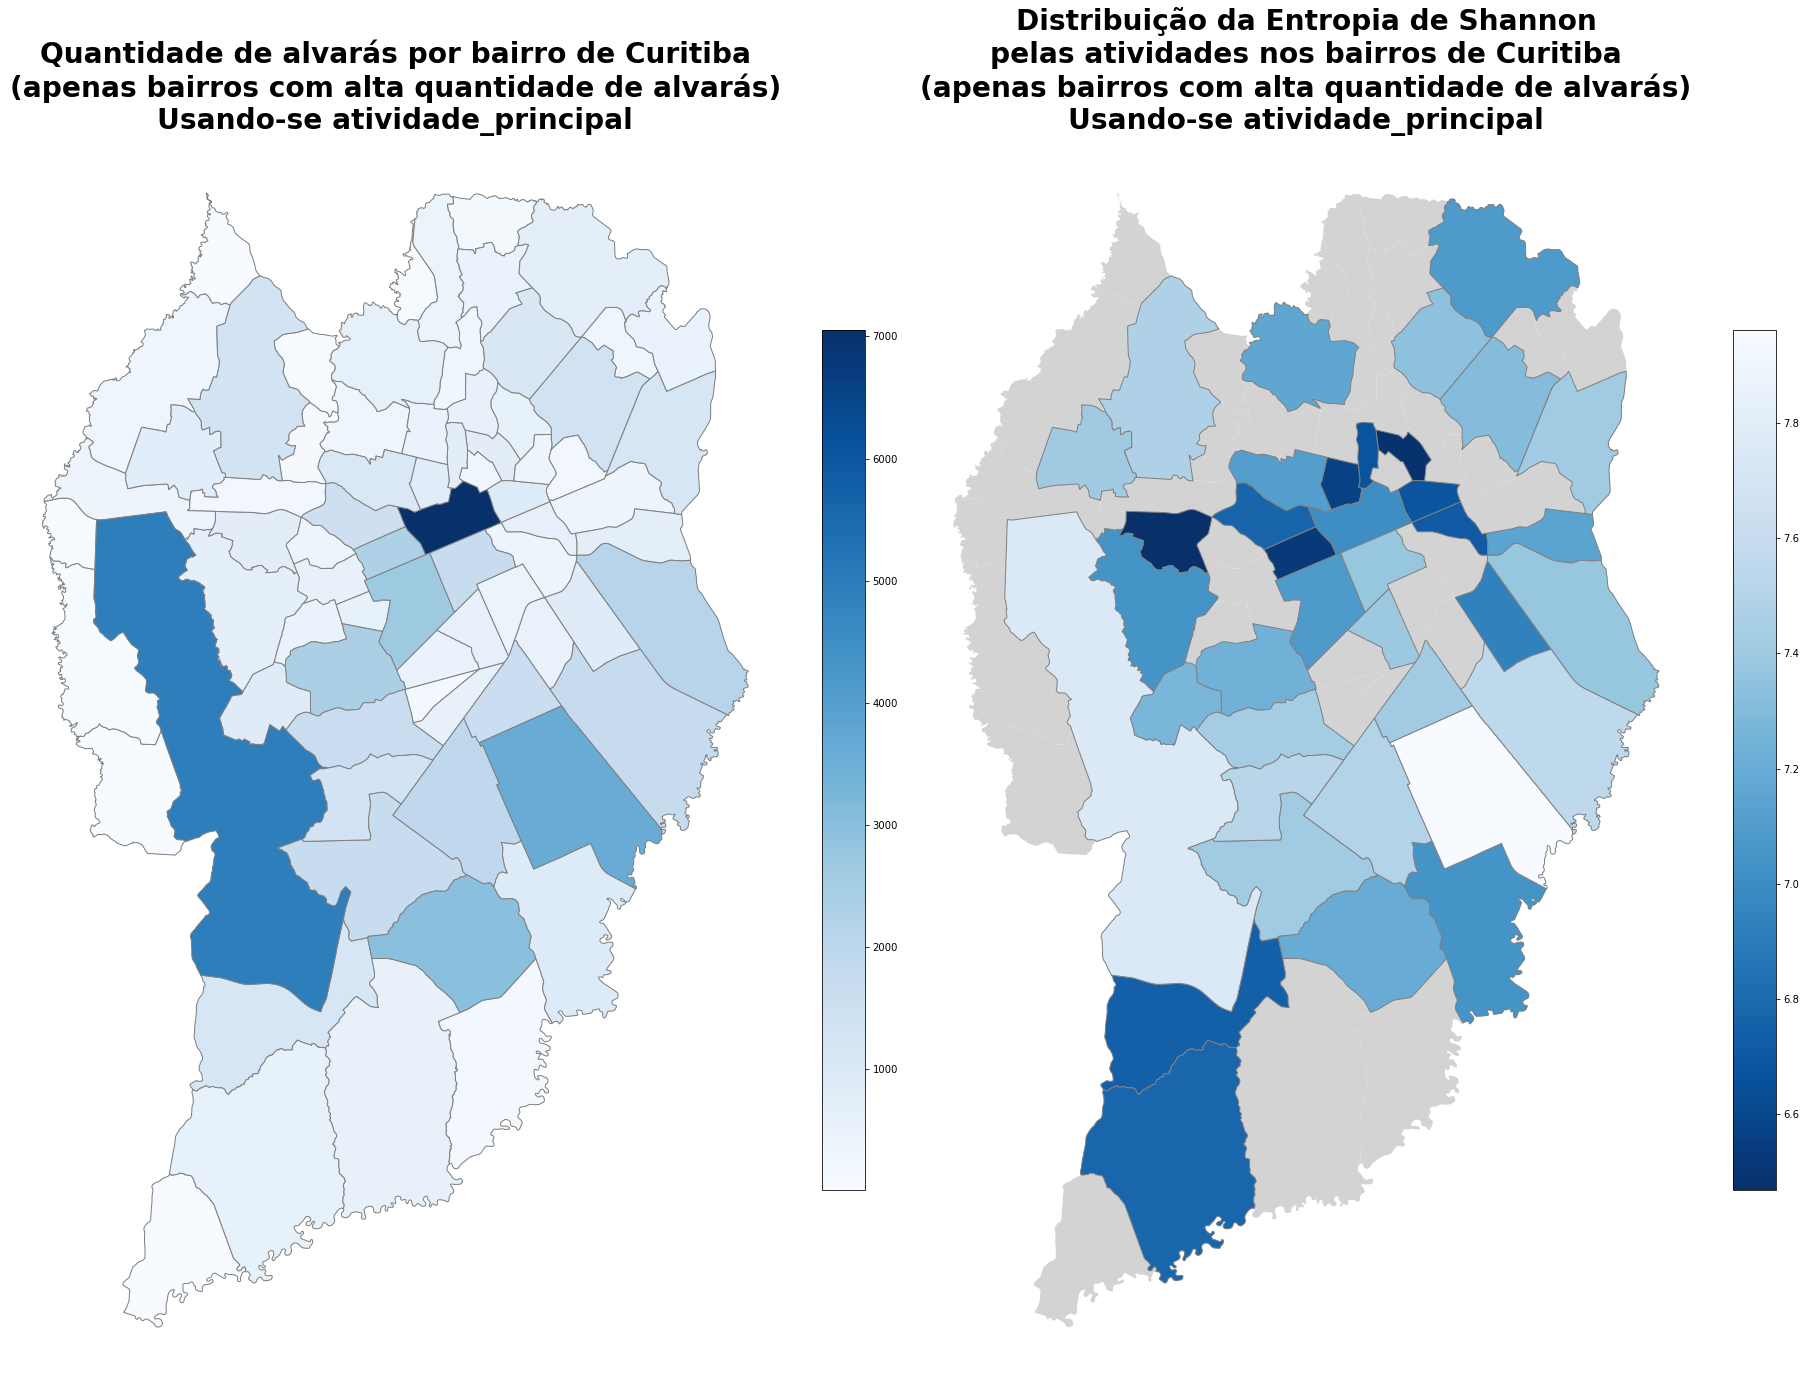

In [73]:
# PLOTAGEM DOS MAPAS LADO A LADO
from matplotlib.gridspec import GridSpec
fig = plt.figure(figsize=(25, 24), constrained_layout=True)

specs = GridSpec(ncols=2, nrows=1, figure=fig)

ax1 = fig.add_subplot(specs[0, 0])
mapa_hs_bairros_ativ_princ_alta_qt.plot(ax = gdf_mapa_bairros.plot(ax=ax1, color = 'lightgray'), column = 'por_bairro', edgecolor='gray', cmap='Blues', legend = True, legend_kwds = {'shrink':.5})
plt.title('Quantidade de alvarás por bairro de Curitiba\n(apenas bairros com alta quantidade de alvarás)\nUsando-se atividade_principal', fontsize = 28, fontweight = 'bold');
plt.axis('off');

ax2 = fig.add_subplot(specs[0, 1])
mapa_hs_bairros_ativ_princ_alta_qt.plot(ax = gdf_mapa_bairros.plot(ax=ax2, color = 'lightgray'), column = 'Hs_ativ_princ', edgecolor='gray', cmap='Blues_r', legend = True, legend_kwds = {'shrink':.5})
plt.title('Distribuição da Entropia de Shannon\npelas atividades nos bairros de Curitiba\n(apenas bairros com alta quantidade de alvarás)\nUsando-se atividade_principal', fontsize = 28, fontweight = 'bold');
plt.axis('off');

### É possível se chegar a qualquer conclusão sobre as ruas?

In [74]:
# Para o agrupamento por rua
df_por_rua = df_alvaras.groupby(by='endereco').size().reset_index(name='por_rua').sort_values(by='por_rua', ascending=False).reset_index(drop=True)
df_por_rua['pi_rua'] = df_por_rua['por_rua'] / len(df_alvaras)
df_por_rua['log_pi_rua'] = np.log(df_por_rua['pi_rua']) / np.log(2)
df_por_rua['hi_rua'] = (-1) * df_por_rua['pi_rua'] * df_por_rua['log_pi_rua']
#df_por_rua['Hs_ativ_usar'] = df_por_rua.apply(lambda x: Entropia_Shannon_Rua('atividade_usar', x['endereco'], df_clas = x, df_geral = df_alvaras), axis = 1)
df_por_rua['Hs_ativ_usar'] = df_por_rua.apply(lambda x: Entropia_Shannon_Rua('atividade_principal', x['endereco'], df_geral = df_alvaras), axis = 1)
df_por_rua = df_por_rua.iloc[:,[0,1,5]].sort_values(by = 'Hs_ativ_usar', ascending = False).reset_index(drop = True)
df_por_rua

,endereco,por_rua,Hs_ativ_usar
0,R. JOAO BETTEGA,393,7.023741
1,AV. SETE DE SETEMBRO,1092,6.788984
2,R. ANNE FRANK,298,6.786899
3,AV. ANITA GARIBALDI,574,6.759737
4,R. DESEMBARGADOR WESTPHALEN,355,6.735584
...,...,...,...
6330,R. CESAR MISAEL CHAVES,1,0.000000
6331,R. CELSO LUIZ DO VALE,1,0.000000
6332,R. CELIA CABRAL SALGUEIRO,1,0.000000
6333,R. CELESTE PASCHOAL MILANI,1,0.000000


<AxesSubplot:xlabel='por_rua'>

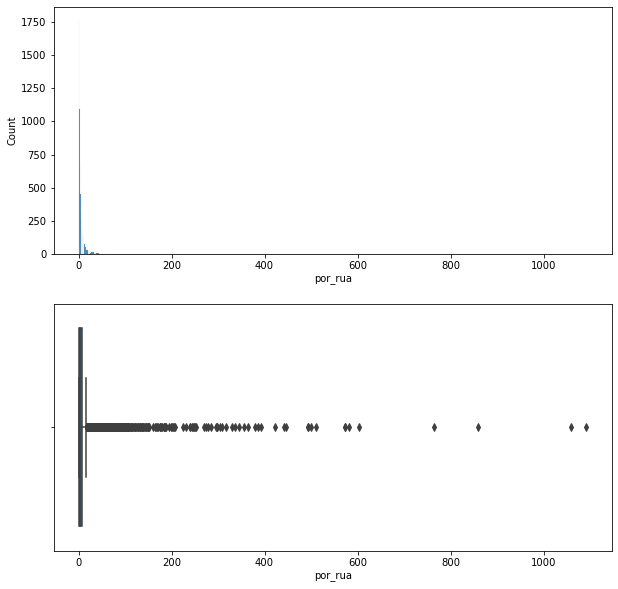

In [75]:
fig_qt_rua = plt.figure(figsize = (10,10))

ax1 = plt.subplot(211)
sns.histplot(data = df_por_rua, x = 'por_rua', ax = ax1)

ax2 = plt.subplot(212)
sns.boxplot(data = df_por_rua, x = 'por_rua', ax = ax2)

<AxesSubplot:xlabel='Hs_ativ_usar', ylabel='Count'>

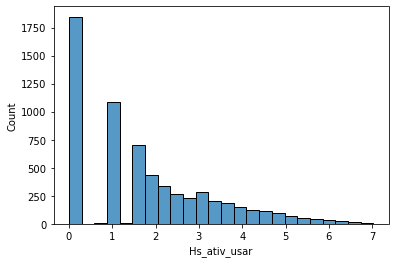

In [76]:
sns.histplot(data = df_por_rua, x = 'Hs_ativ_usar')

<AxesSubplot:xlabel='Hs_ativ_usar'>

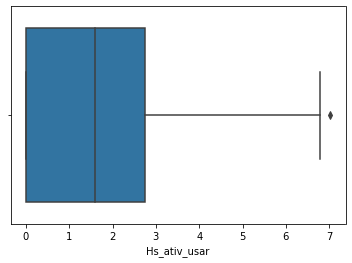

In [77]:
sns.boxplot(data = df_por_rua, x = 'Hs_ativ_usar')

In [78]:
df_por_rua_alta_conc = df_por_rua.loc[df_por_rua.Hs_ativ_usar > 6].reset_index(drop = True)

In [79]:
df_por_rua_alta_conc.sort_values(by = 'por_rua', ascending = False).style

,endereco,por_rua,Hs_ativ_usar
1,AV. SETE DE SETEMBRO,1092,6.788984
5,AV. MARECHAL FLORIANO PEIXOTO,1060,6.705619
19,AV. REPÚBLICA ARGENTINA,859,6.440643
6,AV. MANOEL RIBAS,602,6.699774
3,AV. ANITA GARIBALDI,574,6.759737
15,R. MARECHAL DEODORO,573,6.542847
30,R. PADRE ANCHIETA,510,6.270632
53,R. XV DE NOVEMBRO,500,6.075297
29,AV. CANDIDO DE ABREU,494,6.273488
14,R. FRANCISCO DEROSSO,442,6.543843


<AxesSubplot:xlabel='por_rua'>

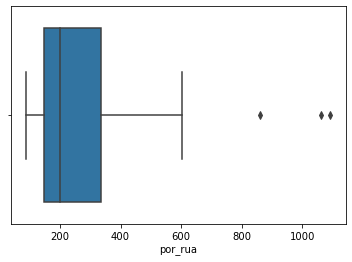

In [80]:
sns.boxplot(data = df_por_rua_alta_conc, x = 'por_rua')

In [ ]:
# df_alvaras['endereco_completo'] = df_alvaras['endereco'] + ', ' + df_alvaras['numero'].astype(str)

# Para o agrupamento por endereço completo (rua + numero)
df_por_end_comp = df_alvaras.groupby(by=['endereco', 'numero']).size().reset_index(name='por_end_comp').sort_values(by='por_end_comp', ascending=False).reset_index(drop=True)
df_por_end_comp['pi_end_comp'] = df_por_end_comp['por_end_comp'] / len(df_alvaras)
df_por_end_comp['log_pi_end_comp'] = np.log(df_por_end_comp['pi_end_comp']) / np.log(2)
df_por_end_comp['hi_end_comp'] = (-1) * df_por_end_comp['pi_end_comp'] * df_por_end_comp['log_pi_end_comp']
df_por_end_comp['Hs_ativ_usar'] = df_por_end_comp.apply(lambda x: Entropia_Shannon_End_Completo('atividade_principal', x['endereco'], x['numero'], df_geral = df_alvaras), axis = 1)
df_por_end_comp = df_por_end_comp.iloc[:,[0,1,6]].sort_values(by = 'Hs_ativ_usar', ascending = False).reset_index(drop = True)
df_por_end_comp